# Feature Engineering

In [1]:
from dill import dumps, loads

In [5]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, plot_metric
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# import sys
# sys.path.append('../missingno')
# import missingno as msno

path = './home-credit-default-risk/'

## Fonctions communes

In [668]:
# Test  to handdle the check file
file_path = 'ModelResults.pkl'
f = open(file_path, 'rb')
ii=0
f.seek(0)
data_list=[]
while True:
    try:
        L = pickle.load(f)
        ii+=1
        print(ii, L[:2])
        data_list.append(L)
    except :
        print("File has been read")
        break
[liste[:2] for liste in data_list]  , len(data_list)      

1 ['Mon, 14 Nov 2022 16:09:45', 'SVC_list_1']
2 ['Mon, 14 Nov 2022 16:10:51', 'NBG_list_1']
3 ['Mon, 14 Nov 2022 20:47:04', 'XGBoost']
4 ['Tue, 15 Nov 2022 11:18:27', 'HistGBM']
5 ['Tue, 15 Nov 2022 12:15:42', 'LightGBM']
6 ['Fri, 18 Nov 2022 21:28:13', 'MLP_sklearn']
7 ['Fri, 18 Nov 2022 21:45:28', 'MLP_TF']
8 ['Fri, 18 Nov 2022 22:21:18', 'small_MLP_TF']
9 ['Mon, 21 Nov 2022 19:19:31', 'RandomForest']
10 ['Tue, 22 Nov 2022 09:39:21', 'LightGBM_bal']
11 ['Tue, 22 Nov 2022 10:59:35', 'XGBoost_bal']
12 ['Tue, 22 Nov 2022 12:16:17', 'NBG_ACP']
13 ['Tue, 22 Nov 2022 12:46:57', 'small_MLP_TF_drop']
14 ['Wed, 23 Nov 2022 22:00:21', 'small_MLP_TF_drop_ACP']
15 ['Fri, 25 Nov 2022 09:09:38', 'small_MLP_TF_drop_slkb']
16 ['Mon, 28 Nov 2022 09:46:47', 'LogReg_ACP']
17 ['Mon, 28 Nov 2022 15:25:52', 'LightGBM_optim1']
18 ['Mon, 28 Nov 2022 18:48:06', 'LightGBM_optim2']
19 ['Mon, 28 Nov 2022 19:45:23', 'LightGBM_optim4']
20 ['Mon, 28 Nov 2022 21:01:38', 'LightGBM_optim3']
21 ['Mon, 28 Nov 2022 21:5

([['Mon, 14 Nov 2022 16:09:45', 'SVC_list_1'],
  ['Mon, 14 Nov 2022 16:10:51', 'NBG_list_1'],
  ['Mon, 14 Nov 2022 20:47:04', 'XGBoost'],
  ['Tue, 15 Nov 2022 11:18:27', 'HistGBM'],
  ['Tue, 15 Nov 2022 12:15:42', 'LightGBM'],
  ['Fri, 18 Nov 2022 21:28:13', 'MLP_sklearn'],
  ['Fri, 18 Nov 2022 21:45:28', 'MLP_TF'],
  ['Fri, 18 Nov 2022 22:21:18', 'small_MLP_TF'],
  ['Mon, 21 Nov 2022 19:19:31', 'RandomForest'],
  ['Tue, 22 Nov 2022 09:39:21', 'LightGBM_bal'],
  ['Tue, 22 Nov 2022 10:59:35', 'XGBoost_bal'],
  ['Tue, 22 Nov 2022 12:16:17', 'NBG_ACP'],
  ['Tue, 22 Nov 2022 12:46:57', 'small_MLP_TF_drop'],
  ['Wed, 23 Nov 2022 22:00:21', 'small_MLP_TF_drop_ACP'],
  ['Fri, 25 Nov 2022 09:09:38', 'small_MLP_TF_drop_slkb'],
  ['Mon, 28 Nov 2022 09:46:47', 'LogReg_ACP'],
  ['Mon, 28 Nov 2022 15:25:52', 'LightGBM_optim1'],
  ['Mon, 28 Nov 2022 18:48:06', 'LightGBM_optim2'],
  ['Mon, 28 Nov 2022 19:45:23', 'LightGBM_optim4'],
  ['Mon, 28 Nov 2022 21:01:38', 'LightGBM_optim3'],
  ['Mon, 28 Nov 2

In [21]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Fonction permettant de sauver les résultats des Modèles
import pickle
import time
import os

# check https://pypi.org/project/klepto/
# check also shelves : https://stackoverflow.com/questions/15114616/remove-or-edit-entry-saved-with-python-pickle
def savedata(myData):
    dataList = []
    replacement =  False
    file_path = 'ModelResults.pkl'
    if not os.path.exists(file_path) : 
        f = open(file_path, 'wb')
        data = [time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())]
        data += myData
        pickle.dump(data, f)
        f.close()
    else : 
        f = open(file_path, 'rb+')
        ii=0
        while True:
            try:
                L = pickle.load(f)
                ii+=1
                if L==[]:
                    print("Entrée vide détectée")
                    break
                elif L[1] == myData[0]:
                    L[0] = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
                    L[1:] = myData
                    replacement = True
                dataList.append(L)
                print(ii, L[:2])
            except :  # EOFError  <= this parameter is not used because in that way we can skip error in last record if any
                print("File has been read")
                break

        # f.close()
        # f = open('model_results.pkl', 'wb')
        f.seek(0)
        
        if not replacement :
            data = [time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())]
            data += myData
            dataList.append(data)

        for i in range(len(dataList)) :
            pickle.dump(dataList[i], f)

        f.close()
        
def get_list():
    file_path = 'ModelResults.pkl'
    f = open(file_path, 'rb')
    model_list=[]
    while True:
        try:
            L = pickle.load(f)
            model_list.append(L)
        except :  # EOFError  <= this parameter is not used because in that way we can skip error in last record if any
            print("Read file")
            break
    f.close()
    return model_list

## Analyse des fichiers

In [8]:
from os import listdir
list_files = [file for file in listdir(path) if file not in ["HomeCredit_columns_description.csv","featureengineeringdata.csv", 
                                                             "data_for_mini_model.csv", "feature_engineered_data.csv", "micro_dataset.csv",
                                                             "shap_values_micro.csv"]]
print(list_files)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [138]:
df = pd.read_csv(path + "application_train.csv", nrows=5)
df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
"EXT_SOURCE_1" in df.columns

True

In [9]:
quantity = 0
for file in list_files :
    df = pd.read_csv(path + file)
    print("la taille du fichier ", file, " est : ", len(df), " lignes, et ", len(df.columns), " colonnes.")
    quantity += len(df)*len(df.columns) 
    # longueur += len(df)
    # colonnes += len(df.columns)
print("Au total, cela fait : ", quantity, " valeurs.")

la taille du fichier  application_test.csv  est :  48744  lignes, et  121  colonnes.
la taille du fichier  application_train.csv  est :  307511  lignes, et  122  colonnes.
la taille du fichier  bureau.csv  est :  1716428  lignes, et  17  colonnes.
la taille du fichier  bureau_balance.csv  est :  27299925  lignes, et  3  colonnes.
la taille du fichier  credit_card_balance.csv  est :  3840312  lignes, et  23  colonnes.
la taille du fichier  installments_payments.csv  est :  13605401  lignes, et  8  colonnes.
la taille du fichier  POS_CASH_balance.csv  est :  10001358  lignes, et  8  colonnes.
la taille du fichier  previous_application.csv  est :  1670214  lignes, et  37  colonnes.
la taille du fichier  sample_submission.csv  est :  48744  lignes, et  2  colonnes.
Au total, cela fait :  493570071  valeurs.


## Traitement des features de chaque dataset

In [22]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    
    maketest = False
    test_df = pd.DataFrame()
    if maketest : 
        test_df = pd.read_csv(path + 'application_test.csv', nrows= num_rows)
        df = df.append(test_df).reset_index()
    
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    # Annuity : Montant à rembourser à chaque période
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [48]:
df = pd.read_csv(path + 'bureau_balance.csv')
df.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [49]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
df.groupby('SK_ID_BUREAU').agg(bb_aggregations).head(5)

MONTHS_BALANCE         
                        min max size
SK_ID_BUREAU                        
5001709                 -96   0   97
5001710                 -82   0   83
5001711                  -3   0    4
5001712                 -18   0   19
5001713                 -21   0   22

In [129]:
df = pd.read_csv(path + 'bureau.csv', nrows = 10)
"SOURCE" in df.columns

False

In [51]:
"DAYS_CREDIT_UPDATE" in pd.read_csv(path + 'bureau.csv', nrows = 10).columns

True

In [23]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: réalise plusieurs aggregations (min max et taille) et fusionne avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']     
    ### check le nombre de mois à l'équilibre (min, max) durée du prêt, 
    ### Taux de fois où le paiement était en retard sur un prêt et quel retard (STATUS)
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    ### merge bureau et bb
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    # Construction du dataset bureau_agg concaténant
    # les données agglomérés pour l'ensemble des crédits
    # + les données agglomérés pour les crédit actif
    # + les données agglomérés pour les crédit fermé
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [24]:
# Preprocess previous_applications.csv
# méthodologie similaire que celle appliquée sur dataset Bureau, 
# cette fois cela concerne les demandes de prêts précédentes faites à Home Credit
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [54]:
df = pd.read_csv(path + 'installments_payments.csv', nrows = 50000)
df[['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']].sample(10)

,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT
779,-124.0,-167.0
42110,-2239.0,-2244.0
31302,-581.0,-581.0
22395,-176.0,-188.0
49931,-874.0,-879.0
5639,-39.0,-51.0
27581,-830.0,-837.0
31033,-218.0,-218.0
38915,-905.0,-914.0
35270,-1974.0,-1978.0


In [25]:
# Preprocess POS_CASH_balance.csv
# idem Bureau sur prêt accordé par Home Credit
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
# Analyse similaire à celle effectué sur Bureau, cette fois sur prêt accordé par Home Credit
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # DPD = Days past due (no negative values)
    # DBD = days before due (no negative values)
    ##### colonne "DAYS_..." renseigné en négatif #####
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
# Traitement des crédits effectués avec la carte de crédit
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [26]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
import re

def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]   
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            n_jobs=4,
            # nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            # silent=-1,
            # verbose=-1, 
        )
      
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', callbacks=[early_stopping(200), log_evaluation(200)]) #  early_stopping_rounds= 200
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [27]:
def dataengineering(debug = True):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

## Creation du DataFrame et traitement des NaN et Infty Values

Il y a énormément de NaN.
La majorité des NaN représentes des valeurs catégoriel et indique que l'information n'est pas connue, 
dans ce cas on considère que l'individu ne possède ou n'appartient pas à la catégorie. On va donc remplacer les NaN par zero.

In [28]:
df_gross = dataengineering(debug = False)
print("dimension Dataframe apres features engineering", df_gross.shape)

Train samples: 307511, test samples: 0
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 27s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 34s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 38s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 23s
dimension Dataframe apres features engineering (307507, 797)


In [41]:
df_gross[np.isinf(df_gross.values).sum(axis=1)>=1].TARGET==1

5687      False
60477     False
79077     False
89018     False
98509      True
126768    False
128791    False
140426    False
152087    False
167136    False
199103    False
201086    False
236164    False
238381    False
272829    False
277962    False
287300     True
292852    False
305373    False
Name: TARGET, dtype: bool

In [88]:
# ici il faudrait remplacer par un entier 0 pour les int64 et par 0. pour les float
df = df_gross.fillna(0.0)
print("remplacement des NaN par 0.0")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
print("dimension Dataframe apres suppression des valeurs infinis", df.shape)

# remove useless columns
useless_columns = list(df.columns[df.nunique()<2])
feats = [f for f in df.columns if f not in useless_columns]
df = df[feats]

print_csv=False
if print_csv:
    df.to_csv('home-credit-default-risk/feature_engineered_data.csv', index=False)

Train samples: 307511, test samples: 0
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 42s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 23s
Installments payments df shape: (339587, 26)
Process installments payments - done in 44s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 28s


# Test de différents modèles

## Read DataFrame

In [19]:
df_full.shape

(307488, 766)

In [15]:
read_csv = True
if read_csv :
    with timer("lecture du dataset"):
        df_full = pd.read_csv('home-credit-default-risk/feature_engineered_data.csv')
df = df_full.copy()

lecture du dataset - done in 25s


## Preprocess

In [163]:
# # remove useless columns
# useless_columns = list(df.columns[df.nunique()<2])
# feats = [f for f in df.columns if f not in useless_columns]
# df = df[feats]

In [164]:
df.shape

(307488, 766)

In [166]:
# print_csv=False
# if print_csv:
#     with timer("écriture du dataset"):
#         df.to_csv('home-credit-default-risk/feature_engineered_data.csv', index=False)

### Preparation d'un subset ayant la même distribition de classes que le set de départ
Clustering sur class 0 et class 1

In [158]:
from sklearn import cluster
from sklearn import decomposition
from sklearn import preprocessing
import random as rd

rd.seed(a=42) 

def reduce_samples(df, ratio=0.2) :
    index_list = []
    for classe in range(2):
        # on réalise un clustering pour la classe 1 et la classe 2
        print("Traitement de la classe {}".format(classe))
        index_class = df[df.TARGET==classe].index

        feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
        scaler = preprocessing.StandardScaler()
        scaled_class = scaler.fit_transform(df[df.TARGET==classe][feats])
        
        print("Dimension du dataset de la classe de départ : {}".format(scaled_class.shape))

        # réduction de dimension du set de départ
        with timer("ACP 99"):
            n_components=0.99
            pca = decomposition.PCA(n_components=n_components, svd_solver="full")
            class_pca = pca.fit_transform(scaled_class)
            print("réduction de dimention avant clustering {}".format(class_pca.shape))
            class_df = pd.DataFrame(class_pca, index=index_class)
            
        # répartition des samples dans des clusters 
        with timer("kmeans"): 
            print("Répartition du dataset dans 100 clusters")
            n_clusters = 100
            # km = cluster.KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
            km = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=1, random_state=42, batch_size=4096)
            km.fit(class_df)

            class_df["clusters"] = km.labels_
        # with timer("dbs"):
        #     dbs = cluster.DBSCAN(eps=0.5, min_samples=10)
        #     dbs.fit(pca_df_95)
        #     clusters_dbs = dbs.labels_
        
        # liste des clusters
        clusters_class_df = class_df.clusters 
        
        # Histogramm : visualisation de la répartition des samples dans chaque clusters
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,2))
        n, bins, patches = plt.hist(clusters_class_df, n_clusters, density=False, facecolor='g', alpha=0.75)
        plt.plot([0, 100], [10, 10], color="red", linestyle='dashed')         
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.title('Histogram of clusters de classe {}' .format(classe))
        # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
        plt.xlim(0, 100)
        # plt.ylim(0, 0.03)
        plt.yscale('log')
        plt.grid(True)
        plt.show()

        # pioche dans chaque cluster un certain nombre (nb_extract) d'index 
        # (pour les 2 classes puisque index_list accumule sur la boucle for "classe")
        
        for ii in clusters_class_df.unique() :
            samples = clusters_class_df[clusters_class_df==ii]
            # nb_extract : nombre de samples à piocher dans le cluster
            nb_extract = int(np.ceil(len(samples)*ratio))
            index_list+=(rd.sample(list(samples.index), nb_extract))

    print("Dimension du dataset {}".format(df[df.index.isin(index_list)].shape))
    
    return df[df.index.isin(index_list)]

## Fonction d'évaluation

In [429]:
dataframe=df_sub_40
feats = [f for f in dataframe.columns if f not in ['TARGET','SK_ID_CURR']]
X_train, X_control, y_train, y_control = model_selection.train_test_split(dataframe[feats], dataframe.TARGET, test_size=0.3,
                                                                        random_state=5, shuffle=True, stratify=dataframe.TARGET)
scaler_transform = make_column_transformer( (preprocessing.StandardScaler(), filter_column_for_scaler), 
                                                                                   # (lambda x: x.columns[x.nunique()>2]) 
                                                                                 # unfortunately lambda funtion cannot be exported to pipeline
                                                ('drop', filter_column_for_drop), # (lambda x: x.columns[x.nunique()==1])
                                                      remainder = "passthrough",
                                                      verbose_feature_names_out = False)
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('u', undersample), ('s', scaler_transform)]
steps.append(('m', model))
pipeline = PipelineImb(steps=steps)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('u',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('s',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <function filter_column_for_scaler at 0x0000019A9718B1F8>),
                                                 ('drop', 'drop',
                                                  <function filter_column_for_drop at 0x0000019A9718B3A8>)],
                                   verbose_feature_names_out=False)),
                ('m',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.03,
                                max_depth=6, min_child_samples=400,
                                n_estimators=600, objective='binary',
                                verbose=-1))])

In [431]:
y_pred_proba = pipeline.predict_proba(X_train)
# auc = roc_auc_score(y_train_tmp, y_pred[:,1])
# y_pred = pipeline.predict(X_train_tmp)

In [438]:
y_pred = pipeline.predict(X_train)
y_pred

In [441]:
len(y_pred)

86154

In [444]:
from sklearn import preprocessing, model_selection, neighbors, metrics, decomposition
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.pipeline import Pipeline as PipelineImb
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import fbeta_score, make_scorer
from lightgbm import record_evaluation

# class _filter_column_for_scaler_:
#     def __init__(self):
#         pass
#     def __call__(self, x):
#         return x.columns[x.nunique()>2]

# class _filter_column_for_drop_:
#     def __init__(self):
#         pass
#     def __call__(self, x):
#         return x.columns[x.nunique()==1]

def filter_column_for_scaler(x):
    return x.columns[x.nunique()>2]
def filter_column_for_drop(x):
    return x.columns[x.nunique()==1]

def evaluation(dataframe, model, params, scoring_param, pipe=None, grid_search=True, make_joblib_for_pythonanywhere=False):
        
# Fonction intégrant une Cross Validation qui permettent d'évaluer les modèles en calculant les métriques suivantes:	
# 	- Mesure le temps de traitement (fit et predict)
# 	- mesure AUC (pour les données non équilibrées): fonction predict_proba ou decision_function
# 	- En complément du score AUC du train “cross-validé”:
# 		* représentation graphique du score AUC de chaque split de la cross validation du fichier train
# 		  pour vérifier la stabilité de ce score et donc la généralisation du modèle
# 		* calcul du score AUC du fichier test en tant que contrôle de cohérence, pour mettre en évidence un éventuel problème de 
#         stratification dans le train_test_split ou une dérive de type data leakage au niveau du fichier train “cross-validé” (par exemple 
#         Smote sur l’ensemble du fichier train avant cross validation)
    
# Différents pipeline sont possibles:
#       None : pas de traitement particulier avant l'application du classifieur
#       'u1sm' : undersampling (ratio 1), standscaler puis application du classifieur
#       'u0_5sm' : undersampling (ratio 0.5), standscaler puis application du classifieur
    
    start = time.time()
    # on utilise 30% du jeu de données pour le test
    test_size_ratio = 0.3
    
    feats = [f for f in dataframe.columns if f not in ['TARGET','SK_ID_CURR']]
    
    # utilisation du clustering réalisé au prélable pour la stratification, il faut que les clusters aient 
    # un nombre d'individus ~mulitple de 10 pour permettre de choisir 30% test et 70% train dans chaque clusters
    X_train, X_control, y_train, y_control = model_selection.train_test_split(dataframe[feats], dataframe.TARGET, test_size=test_size_ratio,
                                                                        random_state=5, shuffle=True, stratify=dataframe.TARGET)

    # scaling
    if make_joblib_for_pythonanywhere :
        print("Make joblib for pythonanywhere.com")
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        scaler_transform = make_column_transformer( (preprocessing.StandardScaler(), make_column_selector(dtype_include=numerics)), 
                                                                                   # (lambda x: x.columns[x.nunique()>2]),
                                                      remainder = "passthrough",
                                                      verbose_feature_names_out = False)   
    else:
        scaler_transform = make_column_transformer( (preprocessing.StandardScaler(), filter_column_for_scaler), 
                                                                                   # (lambda x: x.columns[x.nunique()>2]) 
                                                                                 # unfortunately lambda funtion cannot be exported to pipeline
                                                ('drop', filter_column_for_drop), # (lambda x: x.columns[x.nunique()==1])
                                                      remainder = "passthrough",
                                                      verbose_feature_names_out = False)
    
    print("shape of the X data", np.shape(scaler_transform.fit_transform(dataframe[feats])))
    print("pipe est :{}".format(pipe))
    pipe_status = False
    steps=[]
    steps_names=[]
    # define pipeline
    if pipe == None:
        pipe_status = False
        
    elif pipe == "u1sm":
        pipe_status = True
        # undersampling : sampling_strategy = ratio minority/majority
        undersample = RandomUnderSampler(sampling_strategy=1, random_state=42)
        steps +=[('u', undersample), ('s', scaler_transform)]
        steps_names.append("undersample_1", "scaler_transform")
    elif "u0_5sm" in pipe :
        pipe_status = True
        # undersampling : sampling_strategy = ratio minority/majority
        undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
        steps += [('u', undersample), ('s', scaler_transform)]
        steps_names += ["undersample_0.5", "scaler_transform"]
        # y_train.sum() correspond au nombre d'individus de classe 1
        print("training dataset format for CV : {}".format(y_train.sum()*(2+1)))
    elif "u0_25sm" in pipe :
        pipe_status = True
        # undersampling : sampling_strategy = ratio minority/majority
        undersample = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
        steps += [('u', undersample), ('s', scaler_transform)]
        steps_names += ["undersample_0.25", "scaler_transform"]
    elif "uTL_scaler" in pipe:
        pipe_status = True
        # undersampling : sampling_strategy = ratio minority/majority
        undersample = TomekLinks(sampling_strategy="majority")
        steps += [('u', undersample), ('s', scaler_transform)]
        steps_names += ["undersampleTL_0.25", "scaler_transform"]
    elif "uNM_scaler" in pipe:
        pipe_status = True
        # undersampling : sampling_strategy = ratio minority/majority
        undersample = NearMiss(version=1, sampling_strategy="majority", n_neighbors=3)
        steps += [('u', undersample), ('s', scaler_transform)]
        steps_names += ["undersampleNM_0.25", "scaler_transform"]
    if "_acp" in pipe:
        pipe_status = True
        # undersampling : sampling_strategy = ratio minority/majority
        undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
        a__n_components=[]
        print("Correspondance ratio vers Nombre de composantes")
        # transformation des valeurs de a__n_components: de ratio vers nombre de composantes
        for n_components in params["a__n_components"] :
            acp = PCA(svd_solver="full", n_components=n_components)
            steps_trans = [('u', undersample), ('s', scaler_transform), ('a', acp)]
            pipeline_trans = PipelineImb(steps=steps_trans)
            pipeline_trans.fit(X_train, y_train)
            nb_composantes = pipeline_trans["a"].n_components_
            a__n_components.append(nb_composantes)
            print("    ratio {}   gives {} composantes".format(n_components, nb_composantes))
        steps.append(('a', acp))
        steps_names.append("acp")
        params["a__n_components"] = a__n_components

        # CREATE a ParamGrid with a__n_components and m__ndim evolving conjuently
        if "m__ndim" in params.keys():
            params_trunc = {k: params[k] for k in params.keys() if k not in ["a__n_components", "m__ndim"] }
            print("trunc : {}".format(params_trunc))
            paramgrid=[]
            for ii in params["a__n_components"] :
                params_trunc_plus = params_trunc.copy()
                params_trunc_plus["a__n_components"] = [ii]
                params_trunc_plus["m__ndim"] = [ii]
                paramgrid.append(params_trunc_plus)
                print("morceau de params : {}".format(params_trunc_plus))
            params = paramgrid

    if "_slkb" in pipe:
        pipe_status = True
        slkb = SelectKBest(k=100)
        steps.append(('slkb', slkb))
        steps_names.append("slkb")    
        if "m__ndim" in params.keys():
            params_trunc = {k: params[k] for k in params.keys() if k not in ["slkb__k", "m__ndim"] }
            print("trunc : {}".format(params_trunc))
            paramgrid=[]
            for ii in params["slkb__k"] :
                params_trunc_plus = params_trunc.copy()
                params_trunc_plus["slkb__k"] = [ii]
                params_trunc_plus["m__ndim"] = [ii]
                paramgrid.append(params_trunc_plus)
                print("morceau de params : {}".format(params_trunc_plus))
            params = paramgrid

    if "_smote0_5" in pipe:
        pipe_status = True
        # oversampling : sampling_strategy = Nb minority/ Nb majority
        smotesample = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=2)
        steps.append(('sm', smotesample))
        steps_names.append("smote0_5")
    if "_adasyn0_5" in pipe:
        pipe_status = True
        # oversampling : sampling_strategy = Nb minority/ Nb majority
        adasyn = ADASYN(sampling_strategy=0.5, random_state=42, n_neighbors=2)
        steps.append(('Ad', adasyn))
        steps_names.append("adasyn0_5") 
    if not pipe_status :
        print("pipe n'est pas bien renseigné")
        
    steps.append(('m', model))
    steps_names.append("model")
    print("the pipeline is : {}".format(steps_names))
    # print("the true pipeline is : {}".format(steps))
    pipeline = PipelineImb(steps=steps)
    
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    time_prepa = time.time() - start
    
    # scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    print("Nombre d'échantillon pour le training : {}     Dimension des échantillons : {}" .format(X_train.shape[0], X_train.shape[1]))

    if grid_search==True:
        print("start GridSearchCV")
        
        scoring = scoring_param
        if scoring_param=="ftwo_score" :
            scoring = make_scorer(fbeta_score, beta=2)
        # else : raise error
        
        grid = model_selection.GridSearchCV(pipeline, params, cv=cv, scoring=scoring, verbose=4, error_score='raise') 

        if "_bal" in pipe:
            X_train_trans, y_train_trans = undersample.fit_resample(X_train, y_train)
            weight_class_0 = sum(y_train_trans == 1)/len(y_train_trans)
            weight_class_1 = sum(y_train_trans == 0)/len(y_train_trans)
            print("weight_class_0 = {:2.3f} et weight_class_1 = {:2.3f}" .format(weight_class_0, weight_class_1))
            train_class_weight = [weight_class_0 if sample==0 else weight_class_1 for sample in y_train_trans]
            print("Nombre de classe".format(len(train_class_weight)))
            fit_params = {'m__sample_weight': train_class_weight}
            # params["m__class_weight"] = train_class_weight
            # grid.fit(X_train, y_train, m__sample_weight=train_class_weight)
            # grid.fit(X_train, y_train, fit_params={'sample_weight': train_class_weight})
            grid.fit_params=fit_params
            # grid.fit(X_train, y_train, **fit_params)

        start = time.time() 
        grid.fit(X_train, y_train)
        time_fit = time.time()-start
        print("fitting time : {}" .format(time_fit))

        # predict and compute 'roc_auc'. En cas de pb, utiliser predict_proba ou decision_function
        start = time.time()
        control_score = grid.score(X_control, y_control)
        time_predict = time.time()-start
        print("predict time : {}" .format(time_predict))

        # mise en forme des sorties
        if type(params) == list :
            nbp = len(params[0])
        else:
            nbp = len(params)
        print("number of parameters : ", nbp)
        split_results_df = pd.DataFrame(grid.cv_results_).iloc[:,5+nbp:15+nbp]
        results_df = pd.DataFrame(grid.cv_results_).iloc[:,:4+nbp].join(pd.DataFrame(grid.cv_results_).iloc[:,15+nbp:])

        best_result_df = pd.DataFrame(grid.best_params_, index=["best result"])
        best_result_df["best mean score"] = grid.best_score_
        best_result_df["Control Set score"] = control_score

        # grid.best_estimator_, (time_prepa, time_fit, time_predict)
        return best_result_df, split_results_df, results_df

    if grid_search==False :
        # generate df0 for SHAP
        preproc_params = {arg: params[arg] for arg in params.keys() if "m__" not in arg}
        X_train_trans = pipeline[:-1].fit_transform(X_train, y_train, **preproc_params)
        X_dump, y_train_trans = pipeline[0].fit_sample(X_train, y_train, **preproc_params)
        features_names = pipeline[:-1].get_feature_names_out()
        df0 = pd.DataFrame(X_train_trans, columns=features_names)
        df0['TARGET'] = y_train_trans

        pipeline.set_params(**{'m__verbose':-1})  # pour ne pas afficher des warnings interne à Lightgbm
        
        pipeline.fit(X_train, y_train, **params)
        
        # Lors du fit on utilise under- et over-sampling
        # donc pour calculer auc sur le dataset utilisé lors du fit
        # il faut samplé les données de la même manière que lors du fit.
        X_train_tmp, y_train_tmp = pipeline[0].fit_resample(X_train, y_train)
        y_pred = pipeline.predict_proba(X_train_tmp)
        print(y_pred.shape)
        auc = roc_auc_score(y_train_tmp, y_pred[:,1])
        y_pred = pipeline.predict(X_train_tmp)
        print(y_pred.shape)
        f2_score_ = fbeta_score(y_train_tmp, y_pred[:], beta=2)
        f10_score_ = fbeta_score(y_train_tmp, y_pred[:], beta=10)
        
        print("score sur dataset vu au training, auc : {}".format(auc))
        print("score sur dataset vu au training, f_2 : {}".format(f2_score_))
        print("score sur dataset vu au training, f_10 : {}".format(f10_score_))
    
        y_pred = pipeline.predict_proba(X_control)
        auc = roc_auc_score(y_control, y_pred[:,1])
        y_pred = pipeline.predict(X_control)
        f2_score_ = fbeta_score(y_control, y_pred[:], beta=2)
        f10_score_ = fbeta_score(y_control, y_pred[:], beta=10)
        print("score sur dataset de controle, auc : {}".format(auc))
        print("score sur dataset de contrôle, f_2 : {}".format(f2_score_))
        print("score sur dataset de contrôle, f_10 : {}".format(f10_score_))
        
        return model, df0, pipeline, X_control, y_control

# display bar graph of AUC values for each model for comparison
def AUC_split_graph(split_results_df, results_df, titre) :
    score_split_graph(split_results_df, results_df, titre)
    
def score_split_graph(split_results_df, results_df, titre) :   
    fig = plt.figure(figsize=(4, 2))
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    ax = fig.subplots(1, 1)
    rank = results_df.rank_test_score
    for ii in range(len(split_results_df)):
        # display only the 5 first results
        if rank[ii]<=5 : ax.plot(np.arange(10), split_results_df.iloc[ii], label=rank[ii])  
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    y_min = min(results_df.mean_test_score)-max(results_df.std_test_score)*5
    y_max = max(results_df.mean_test_score)+max(results_df.std_test_score)*5
    plt.ylim([y_min,y_max])
    plt.xlabel('split')
    plt.ylabel('AUC')
    plt.title('AUC for each split with {}' .format(titre));

# Compute and display Shapley_values
from scipy.special import logit
import shap

def show_features_importances(df0, features_names, model, sample_num=None):
 
    explainer = shap.TreeExplainer(model)
    start = time.time()
    shap_values = explainer.shap_values(df0[features_names].values)
    time_shapvalues = time.time()-start
    print("shapvalues computing time : {}" .format(time_shapvalues))
    
    # Display the mean of absolute values of the shapley values
    if sample_num==None:
        fig = plt.figure(figsize=(6, 8))
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['figure.facecolor'] = 'white'
        fig.add_subplot(2, 1, 1)
        shap.summary_plot(shap_values[1], df0[features_names],  max_display=10, plot_type="bar", plot_size=None, show=False)
        plt.title("SHAP : Features Importance computed with All features in pipeline")
        fig.tight_layout()  
        # plt.figure(facecolor='yellow')
        plt.show()
        
    # Display the  shapley values for one sample
    else:
        X_train_tmp = df0[features_names].values
        proba = model.predict_proba(X_train_tmp[sample_num,:].reshape(1,-1))[0][1]
        prediction = model.predict(X_train_tmp[sample_num,:].reshape(1,-1))
        print("Numéro d'échantillon : {}, proba d'être dans la classe 1: {:2.3%}, logit(p): {:2.3f}."
          .format(sample_num, proba,  (lambda x: logit(x))(proba)) )
        shap_value_0 = explainer.expected_value[1]
        sum_shap_values_wo_0 = np.sum(shap_values[1][sample_num])
        sum_shapley_values  = shap_value_0 + sum_shap_values_wo_0
                                                       
        print("shap_value_0 ({:2.3f}) + sum shap values ({:2.3f}) = {:2.3f}"
              .format( shap_value_0, sum_shap_values_wo_0,  sum_shapley_values))
        print("classe prédite : {}" .format(prediction))

        mean_proba = df0.TARGET.mean(0)

        print("Valeur de base estimée par SHAP : {:2.2f}" 
              .format(explainer.expected_value[1]))
        print("Mean_proba: {:2.2%}, Logit de mean_proba: {:2.3f}" 
              .format(mean_proba, (lambda x: logit(x))(mean_proba)))
        
        shap.force_plot(explainer.expected_value[1], shap_values[1][sample_num,:], 
                        df0[features_names].iloc[sample_num,:], matplotlib=True) # show=False
        # plt.savefig('force_plot.png')
        
        plt.show()
    # Notice : force_plot display the values of the the features in the order of the shapley importance values.
    # la valeur au centre est le logit de la proba (sachant que pour p=0.5, le logit vaut 0)
   
    # la liste shap_values est de dimension 2, elle contient les shapley values pour la classe 0 et pour la classe 1
    # la forme est donc 2 x n_features x n_samples
    # Ici on ne s'intéresse que au valeur pour la classe 1.
    return shap_values[1]

## Benchmark of models

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from warnings import catch_warnings, filterwarnings

### reducing samples

In [15]:
debug=True
num_rows = 10000 if debug else len(df)

Traitement de la classe 0
Dimension du dataset de la classe de départ : (282665, 764)
réduction de dimention avant clustering (282665, 488)
ACP 99 - done in 58s
Répartition du dataset dans 100 clusters
kmeans - done in 4s


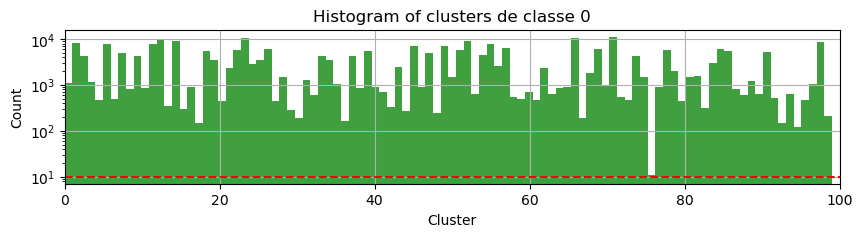

Traitement de la classe 1
Dimension du dataset de la classe de départ : (24823, 764)
réduction de dimention avant clustering (24823, 463)
ACP 99 - done in 4s
Répartition du dataset dans 100 clusters
kmeans - done in 3s


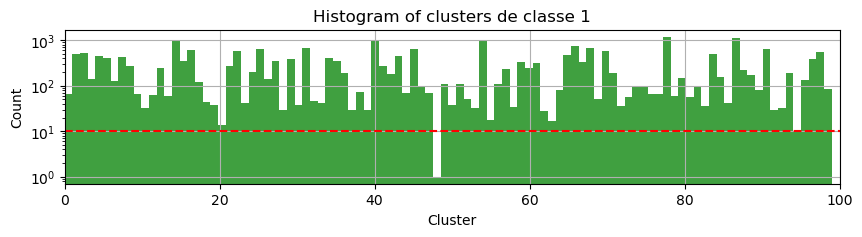

Dimension du dataset (30840, 766)


In [10]:
df_sub = reduce_samples(df, ratio=0.1)

### Essai 1 Dummy : RandomUnderSampler (sampling_strategy=1)

(30840, 766)
0    28311
1     2529
Name: TARGET, dtype: int64
shape of the X data (30840, 764)
start GridSearchCV
fitting time : 8.116178274154663
predict time : 0.08810138702392578
number of parameters :  1


,m__strategy,best mean score,Control Set score
best result,stratified,0.504013,0.500003


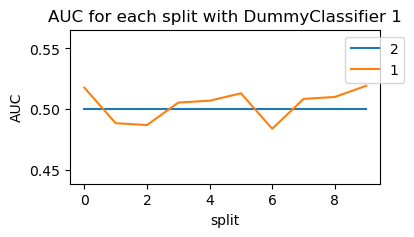

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# model to be tested
model = DummyClassifier(random_state=42)
params = {'m__strategy': ["prior", "stratified"] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())
pipe = "u1sm"
best_result_df, split_results_df, results_df= evaluation(df_sub, model, params, pipe=pipe)
Dummy1_list = [best_result_df, split_results_df, results_df, params, pipe]
AUC_split_graph(split_results_df, results_df, titre="DummyClassifier 1")
best_result_df

### Essai 2 Dummy : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
start GridSearchCV
fitting time : 8.842989683151245
predict time : 0.08380961418151855
number of parameters :  1


,m__strategy,best mean score,Control Set score
best result,most_frequent,0.5,0.5


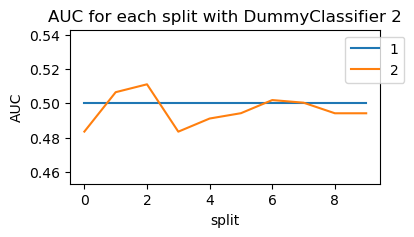

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# model to be tested
model = DummyClassifier(random_state=42)
params = {'m__strategy': ["most_frequent", "stratified"] }

pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
Dummy2_list = [best_result_df, split_results_df, results_df, params, pipe]
AUC_split_graph(split_results_df, results_df, titre="DummyClassifier 2")
best_result_df

### Essai 3 Logistic Regression : RandomUnderSampler (sampling_strategy=1)

(30840, 766)
0    28311
1     2529
Name: TARGET, dtype: int64
shape of the X data (30840, 764)
start GridSearchCV
number of parameters :  3


,m__class_weight,m__max_iter,m__penalty,best mean score,Control Set score
best result,balanced,500,l2,0.697959,0.714607


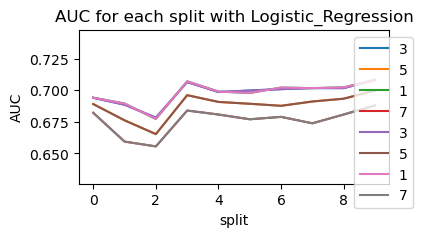

In [418]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from warnings import catch_warnings, filterwarnings

model = LogisticRegression(dual=False)
params = {'m__penalty': ["l2", "none"], 'm__class_weight': ['balanced', None], 'm__max_iter':[100, 500] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    pipe = "u1sm"
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
LogReg_list = [best_result_df, split_results_df, results_df, params, pipe]
AUC_split_graph(split_results_df, results_df, titre="Logistic_Regression Essai 3")
best_result_df

### Essai 4 Logistic Regression : RandomUnderSampler (sampling_strategy=0.5)

(30840, 766)
0    28311
1     2529
Name: TARGET, dtype: int64
shape of the X data (30840, 764)
start GridSearchCV
number of parameters :  3


,m__class_weight,m__max_iter,m__penalty,best mean score,Control Set score
best result,None,500,l2,0.7127,0.724183


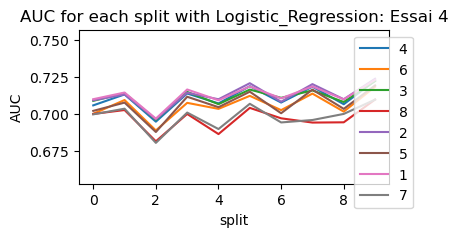

In [419]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from warnings import catch_warnings, filterwarnings

model = LogisticRegression(dual=False)
params = {'m__penalty': ["l2", "none"], 'm__class_weight': ['balanced', None], 'm__max_iter':[100, 500] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    pipe = "u0_5sm"
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
LogReg_list = [best_result_df, split_results_df, results_df, params, pipe]
AUC_split_graph(split_results_df, results_df, titre="Logistic_Regression: Essai 4")
best_result_df

### Essai 4B Logistic Regression avec ACP : RandomUnderSampler (sampling_strategy=0.5)

(30840, 766)
0    28311
1     2529
Name: TARGET, dtype: int64
shape of the X data (30840, 751)
pipe est :u0_5sm_acp
Correspondance ratio vers Nombre de composantes
    ratio 0.999   gives 481 composantes
the pipeline is : ['undersample_0.5', 'scaler_transform', 'acp', 'model']
Nombre d'échantillon pour le training : 21588     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END a__n_components=481, m__class_weight=balanced, m__max_iter=100, m__penalty=l2;, score=0.727 total time=   1.7s
[CV 2/10] END a__n_components=481, m__class_weight=balanced, m__max_iter=100, m__penalty=l2;, score=0.703 total time=   1.7s
[CV 3/10] END a__n_components=481, m__class_weight=balanced, m__max_iter=100, m__penalty=l2;, score=0.716 total time=   2.1s
[CV 4/10] END a__n_components=481, m__class_weight=balanced, m__max_iter=100, m__penalty=l2;, score=0.706 total time=   1.7s
[CV 5/10] END a__n_components=481, m__class_weight=balanced

,a__n_components,m__class_weight,m__max_iter,m__penalty,best mean score,Control Set score
best result,481,None,100,l2,0.709758,0.713912


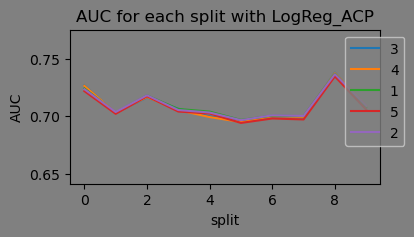

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from warnings import catch_warnings, filterwarnings

model = LogisticRegression(dual=False)
params = {'m__penalty': ["l2", "none"], 'm__class_weight': ['balanced', None], 'm__max_iter':[100, 500],
          "a__n_components":[0.999] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    pipe = "u0_5sm_acp"
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)

LogReg_ACP_list = ["LogReg_ACP", best_result_df, split_results_df, results_df, params, pipe]
savedata(LogReg_ACP_list)
AUC_split_graph(split_results_df, results_df, titre="LogReg_ACP")
best_result_df

### Essai 5 KNN : RandomUnderSampler (sampling_strategy=0.5)

(30840, 766)
0    28311
1     2529
Name: TARGET, dtype: int64
shape of the X data (30840, 764)
start GridSearchCV
number of parameters :  3


,m__leaf_size,m__n_neighbors,m__weights,best mean score,Control Set score
best result,10,20,distance,0.640596,0.637423


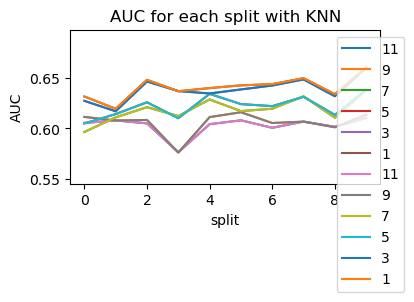

In [420]:
model = KNeighborsClassifier()
params = {'m__n_neighbors': [5, 10, 20], 'm__leaf_size': [10, 30], 'm__weights':["uniform", "distance"] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())
pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
KNN_list = [best_result_df, split_results_df, results_df, params, pipe]
AUC_split_graph(split_results_df, results_df, titre="KNN")
best_result_df

### Essai 6 SVM : RandomUnderSampler (sampling_strategy=0.5)

In [430]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_m__C,param_m__class_weight,mean_test_score,std_test_score,rank_test_score
0,6.256006,0.203127,9.019169,0.212668,1,None,0.723416,0.008272,1


shape of the X data (30840, 764)
start GridSearchCV
fitting time : 3904.074057817459
predict time : 43.212584018707275
number of parameters :  3


,m__C,m__class_weight,m__gamma,best mean score,Control Set score
best result,0.1,balanced,0.1,0.569982,0.549061


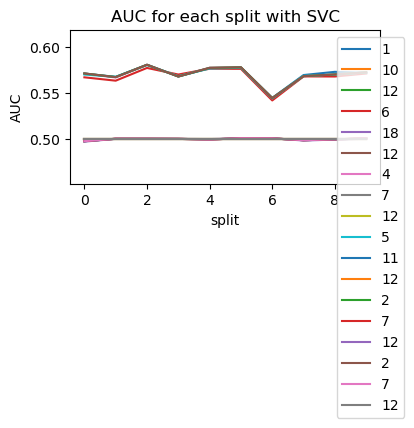

In [434]:
from sklearn.svm import SVC
model = SVC(cache_size=2000, shrinking=False, tol=1e-2)
params = {'m__C': [0.1, 1, 10], 'm__class_weight': ['balanced', None], 'm__gamma':[0.1, 1, 10] }

pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
SVC_list_0 = ["SVC_list_0", best_result_df, split_results_df, results_df, params, pipe]
AUC_split_graph(split_results_df, results_df, titre="SVC")
best_result_df

shape of the X data (30840, 764)
start GridSearchCV
fitting time : 1344.3759121894836
predict time : 23.6091251373291
number of parameters :  3


,m__C,m__class_weight,m__gamma,best mean score,Control Set score
best result,0.01,None,0.001,0.72323,0.710529


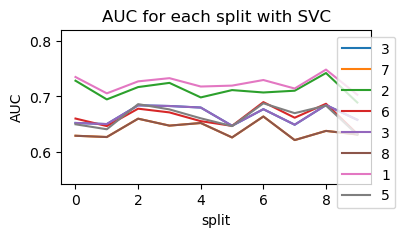

In [19]:
from sklearn.svm import SVC
model = SVC(cache_size=2000, shrinking=False, tol=1e-2)
params = {'m__C': [0.001, 0.01], 'm__class_weight': ['balanced', None], 'm__gamma':[0.001, 0.01] }

pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
SVC_list_1 = ["SVC_list_1", best_result_df, split_results_df, results_df, params, pipe]
savedata(SVC_list_1)
AUC_split_graph(split_results_df, results_df, titre="SVC")
best_result_df

### Essai 7  Naive Bayes : RandomUnderSampler (sampling_strategy=0.5)

In [49]:
file_path = "modelresults_.pkl"
f = open(file_path, 'rb')
L = pickle.load(f)
f.close()
L[0]

'Mon, 14 Nov 2022 16:09:45'

shape of the X data (30840, 764)
start GridSearchCV
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .................................., score=0.520 total time=   0.5s
[CV 2/10] END .................................., score=0.533 total time=   0.4s
[CV 3/10] END .................................., score=0.534 total time=   0.4s
[CV 4/10] END .................................., score=0.522 total time=   0.4s
[CV 5/10] END .................................., score=0.579 total time=   0.5s
[CV 6/10] END .................................., score=0.541 total time=   0.4s
[CV 7/10] END .................................., score=0.545 total time=   0.4s
[CV 8/10] END .................................., score=0.510 total time=   0.4s
[CV 9/10] END .................................., score=0.566 total time=   0.5s
[CV 10/10] END ................................., score=0.539 total time=   0.4s
fitting time : 5.71808648109436
predict time : 0.19466304779052734
number of 

,best mean score,Control Set score
best result,0.538989,0.520655


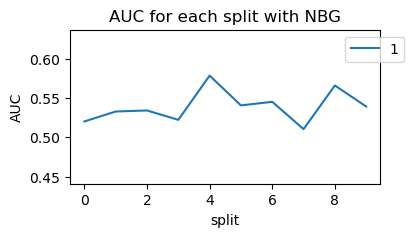

In [50]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
params = {}

pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
NBG_list_1 = ["NBG_list_1", best_result_df, split_results_df, results_df, params, pipe]
savedata(NBG_list_1)
AUC_split_graph(split_results_df, results_df, titre="NBG")
best_result_df

### Essai 8  xgboost : RandomUnderSampler (sampling_strategy=0.5)

In [52]:
import xgboost as xgb
xgb.__version__

'1.5.0'

shape of the X data (30840, 764)
start GridSearchCV
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.773 total time=  15.6s
[CV 2/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.735 total time=  15.5s
[CV 3/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.740 total time=  15.3s
[CV 4/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.744 total time=  16.0s
[CV 5/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.745 total time=  16.4s
[CV 6/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.755 total time=  15.1s
[CV 7/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=1, m__n_estimators=500;, score=0.754 t

,m__learning_rate,m__max_depth,m__min_child_weight,m__n_estimators,best mean score,Control Set score
best result,0.02,3,10,500,0.75031,0.739992


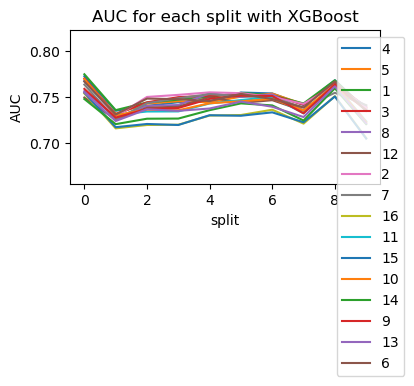

In [59]:
import warnings
model = xgb.XGBClassifier(eval_metric="logloss")
params =  {'m__max_depth': [3, 6], 'm__n_estimators': [500, 1000], "m__learning_rate": [0.02, 0.005], "m__min_child_weight":[1, 10]} 

pipe = "u0_5sm"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
XGBoost_list = ["XGBoost", best_result_df, split_results_df, results_df, params, pipe]
savedata(XGBoost_list)
AUC_split_graph(split_results_df, results_df, titre="XGBoost")
best_result_df

### Essai 9  HistGradientBoostingClassifier : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
start GridSearchCV
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.747 total time=   9.3s
[CV 2/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.728 total time=   8.9s
[CV 3/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.726 total time=   9.0s
[CV 4/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.739 total time=   9.4s
[CV 5/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.733 total time=   8.9s
[CV 6/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.730 total time=   9.0s
[CV 7/10] END m__learning_rate=0.1, m__max_depth=3, m__max_iter=500, m__min_samples_leaf=20;, score=0.743 total time=   9.1s
[CV 8/10] 

,m__learning_rate,m__max_depth,m__max_iter,m__min_samples_leaf,best mean score,Control Set score
best result,0.05,3,500,50,0.746879,0.742444


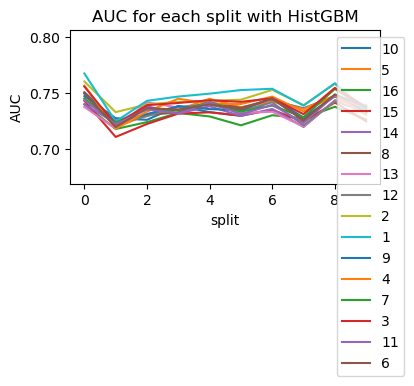

In [72]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(loss="binary_crossentropy")
params =  {'m__max_depth': [3, 6], 'm__max_iter': [500, 1000], "m__learning_rate": [0.1, 0.05], "m__min_samples_leaf":[20, 50]} 

pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
HistGBM_list = ["HistGBM", best_result_df, split_results_df, results_df, params, pipe]
savedata(HistGBM_list)
AUC_split_graph(split_results_df, results_df, titre="HistGBM")
best_result_df

In [82]:
ModelList = get_list()

Read file


In [83]:
ModelList[3][:2]

['Tue, 15 Nov 2022 11:18:27', 'HistGBM']

### Essai 10  LightGBM : RandomUnderSampler (sampling_strategy=0.5)

In [111]:
len(df.columns[df.columns.str.contains('[^A-Za-z0-9_ ]+', case=False)])

54

shape of the X data (30840, 764)
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.739 total time=   2.3s
[CV 2/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.721 total time=   1.9s
[CV 3/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.732 total time=   2.0s
[CV 4/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.740 total time=   2.0s
[CV 5/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.730 total time=   2.0s
[CV 6/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.724 total time=   1.9s
[CV 7/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.745 total time=   2.0s
[CV 8/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.731 total time=   1.9s
[CV 9/10] END m

,m__learning_rate,m__max_depth,m__min_child_samples,best mean score,Control Set score
best result,0.05,3,50,0.746755,0.743797


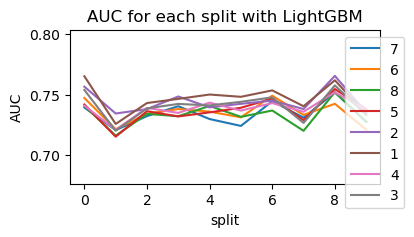

In [88]:
model = LGBMClassifier(objective="binary", n_estimators=500)

params =  {'m__max_depth': [3, 6], "m__learning_rate": [0.1, 0.05], "m__min_child_samples":[20, 50]} 
pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_list = ["LightGBM", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM")
best_result_df

In [112]:
ModelList = get_list()
len(ModelList), [ModelList[ii][1] for ii in range(len(ModelList))]

Read file


(5, ['SVC_list_1', 'NBG_list_1', 'XGBoost', 'HistGBM', 'LightGBM'])

### Essai 11  MLP sklearn : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.679 total time=  11.7s
[CV 2/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.676 total time=  11.7s
[CV 3/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.684 total time=  12.1s
[CV 4/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.693 total time=  12.1s
[CV 5/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.670 total time=  12.5s
[CV 6/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.664 total time=  12.1s
[CV 7/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=0.685 total time=  11.9s
[CV 8/10] END m__activation=relu, m__batch_size=256, m__learning_rate_init=0.001;, score=

,m__activation,m__batch_size,m__learning_rate_init,best mean score,Control Set score
best result,tanh,1024,0.001,0.694868,0.67598


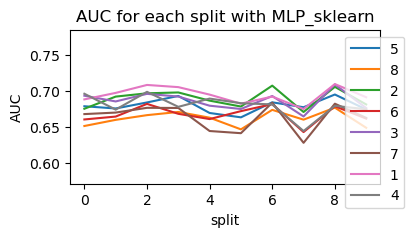

In [266]:
from sklearn.neural_network import MLPClassifier

import warnings
ndim = df_sub.shape[1]

# initial hyperparameters
ndim = df_sub.shape[1]
dense_1_size = int(ndim/2)
dense_2_size = int(ndim/4)
epochs = 20 

model = MLPClassifier(
    hidden_layer_sizes=(dense_1_size, dense_2_size),
    solver="adam", 
    early_stopping=False,
    max_iter=epochs,
    random_state=42)

params =  {'m__activation': ["relu", "tanh"], "m__learning_rate_init": [0.001, 0.01], "m__batch_size":[256, 1024]} 
pipe = "u0_5sm"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
MLP_sklearn_list = ["MLP_sklearn", best_result_df, split_results_df, results_df, params, pipe]
savedata(MLP_sklearn_list)
AUC_split_graph(split_results_df, results_df, titre="MLP_sklearn")
best_result_df

### Essai 12  MLP_TF : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
start GridSearchCV
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END m__activation_hidden_layers=relu, m__batch_size=1024, m__class_weight=None, m__optimizer=adam, m__optimizer__learning_rate=0.001;, score=0.692 total time=   3.4s
[CV 2/10] END m__activation_hidden_layers=relu, m__batch_size=1024, m__class_weight=None, m__optimizer=adam, m__optimizer__learning_rate=0.001;, score=0.696 total time=   3.7s
[CV 3/10] END m__activation_hidden_layers=relu, m__batch_size=1024, m__class_weight=None, m__optimizer=adam, m__optimizer__learning_rate=0.001;, score=0.707 total time=   3.5s
[CV 4/10] END m__activation_hidden_layers=relu, m__batch_size=1024, m__class_weight=None, m__optimizer=adam, m__optimizer__learning_rate=0.001;, score=0.700 total time=   3.4s
[CV 5/10] END m__activation_hidden_layers=relu, m__batch_size=1024, m__class_weight=None, m__optimizer=adam, m__optimizer__learning_rate=0.001;, score=0.697 total time=   3.8s
[CV 6

,m__activation_hidden_layers,m__batch_size,m__class_weight,m__optimizer,m__optimizer__learning_rate,best mean score,Control Set score
best result,relu,1024,None,adam,0.001,0.695042,0.679221


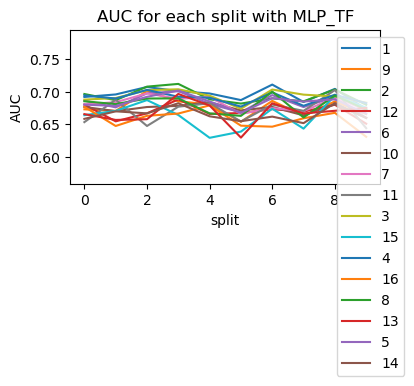

In [268]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC, Recall
from scikeras.wrappers import KerasClassifier

# initial hyperparameters
ndim = df_sub.shape[1]
dense_1_size = int(ndim/2)
dense_2_size = int(ndim/4)
epochs = 20

def initialize_model(ndim=ndim, dense_1_size=dense_1_size, dense_2_size=dense_2_size, activation_hidden_layers="relu"):   
    model = Sequential()
    # dimension des données d'entrées qui correspond au nombre de colonnes de X_train
    model.add(Input(shape=(ndim-2))) 

    model.add(layers.Dense(dense_1_size, input_dim=2, activation='relu'))    
    # model.add(layers.Dropout(0.5, seed=42))  
    model.add(layers.Dense(dense_2_size, input_dim=2, activation='relu'))
    # model.add(layers.Dropout(0.5, seed=42))
    model.add(layers.Dense(1, activation='sigmoid'))

    # model.compile(metrics=[AUC(), Recall()], loss='binary_crossentropy')
    return model

# intialisation
model = KerasClassifier(initialize_model, epochs=epochs, batch_size=1024, verbose=0, 
                metrics=[AUC(), Recall()], loss='binary_crossentropy', activation_hidden_layers="relu",
                class_weight="balanced")
#     Les paramètres du solver peuvent être gérer directement par KerasClassifier:
# ces paramètres (optimizer et sous paramètres, loss, epochs, etc ...) 
# n'ont pas besoin d'être mentionner/déclarer lors de l'initialisation 
# pour être utiliser comme hyperparamètres avec GridSearch.
#     Par contre les paramètres qui n'ont pas de lien avec le solver,
# i.e. les paramètres du constructeur de réseau, doivent être déclarer/mentionner
# à la fois dans KerasClassifier et dans le constructeur du MLP

params = {"m__optimizer": ["adam"], 
          "m__batch_size" : [1024, 256],
          "m__optimizer__learning_rate" : [.001 , .01],
          "m__activation_hidden_layers" : ["relu", "tanh"],
          "m__class_weight": [None, "balanced"]
         } 
pipe = "u0_5sm"

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
MLP_TF_list = ["MLP_TF", best_result_df, split_results_df, results_df, params, pipe]
savedata(MLP_TF_list)
AUC_split_graph(split_results_df, results_df, titre="MLP_TF")
best_result_df

### Essai 13  smallMLP_TF : RandomUnderSampler (sampling_strategy=0.5)

In [286]:
(lambda x : 764*x + x**2/2 + x/2)(24)

18636.0

Model: "sequential_354"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1049 (Dense)          (None, 128)               97920     
                                                                 
 dense_1050 (Dense)          (None, 64)                8256      
                                                                 
 dense_1051 (Dense)          (None, 1)                 65        
                                                                 
Total params: 106,241
Trainable params: 106,241
Non-trainable params: 0
_________________________________________________________________
None
shape of the X data (30840, 764)
Nombre d'échantillon : 21588     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10] END m__activation_hidden_layers=relu, m__class_weight=None, m__dense_size=128;, score=0.708 total time=   2.2s
[CV

,m__activation_hidden_layers,m__class_weight,m__dense_size,best mean score,Control Set score
best result,tanh,balanced,16,0.716359,0.706245


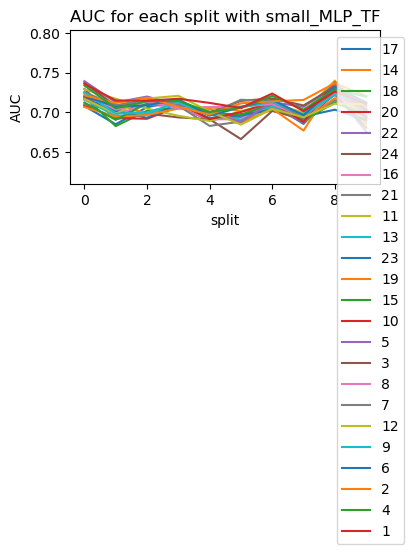

In [289]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.metrics import AUC, Recall
from scikeras.wrappers import KerasClassifier

# initial hyperparameters
ndim = df_sub.shape[1]-2
dense_1_size = int(ndim/2)
dense_2_size = int(ndim/4)
epochs = 20

def initialize_model(ndim=ndim, dense_size=128, activation_hidden_layers="relu"):   
    dense_1_size = dense_size
    dense_2_size = int(dense_size/2)
    
    model = Sequential()
    # dimension des données d'entrées qui correspond au nombre de colonnes de X_train
    model.add(Input(shape=(ndim))) 
    model.add(layers.Dense(dense_1_size, input_dim=2, activation=activation_hidden_layers))    
    # model.add(layers.Dropout(0.5, seed=42))  
    model.add(layers.Dense(dense_2_size, input_dim=2, activation=activation_hidden_layers))
    # model.add(layers.Dropout(0.5, seed=42))
    model.add(layers.Dense(1, activation='sigmoid'))

    # model.compile(metrics=[AUC(), Recall()], loss='binary_crossentropy')
    return model

print(initialize_model().summary())

# intialisation
model = KerasClassifier(initialize_model, epochs=epochs, batch_size=1024, verbose=0, optimizer="adam",
                metrics=[AUC(), Recall()], loss='binary_crossentropy', activation_hidden_layers="relu",
                class_weight="balanced", dense_size=128)
#     Les paramètres du solver peuvent être gérer directement par KerasClassifier:
# ces paramètres (optimizer et sous paramètres, loss, epochs, etc ...) 
# n'ont pas besoin d'être mentionner/déclarer lors de l'initialisation 
# pour être utiliser comme hyperparamètres avec GridSearch.
#     Par contre les paramètres qui n'ont pas de lien avec le solver,
# i.e. les paramètres du constructeur de réseau, doivent être déclarer/mentionner
# à la fois dans KerasClassifier et dans le constructeur du MLP

params = {"m__dense_size" : [128, 64, 32, 24, 20, 16],
#          "m__optimizer__learning_rate" : [.001 , .01],
          "m__activation_hidden_layers" : ["relu", "tanh"],
          "m__class_weight": [None, "balanced"]
         } 
pipe = "u0_5sm"

best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
small_MLP_TF_list = ["small_MLP_TF", best_result_df, split_results_df, results_df, params, pipe]
savedata(small_MLP_TF_list)
AUC_split_graph(split_results_df, results_df, titre="small_MLP_TF")
best_result_df

### Essai 14  Random Forest : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
Nombre d'échantillon : 21588     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10] END m__class_weight=balanced, m__max_depth=5, m__min_impurity_decrease=0.01, m__min_samples_leaf=10, m__n_estimators=100;, score=0.702 total time=   1.2s
[CV 2/10] END m__class_weight=balanced, m__max_depth=5, m__min_impurity_decrease=0.01, m__min_samples_leaf=10, m__n_estimators=100;, score=0.643 total time=   0.8s
[CV 3/10] END m__class_weight=balanced, m__max_depth=5, m__min_impurity_decrease=0.01, m__min_samples_leaf=10, m__n_estimators=100;, score=0.656 total time=   0.8s
[CV 4/10] END m__class_weight=balanced, m__max_depth=5, m__min_impurity_decrease=0.01, m__min_samples_leaf=10, m__n_estimators=100;, score=0.667 total time=   0.8s
[CV 5/10] END m__class_weight=balanced, m__max_depth=5, m__min_impurity_decrease=0.01, m__min_samples_leaf=10, m__n_estimators=100;, score=0.652 total time=   0.8s

,m__class_weight,m__max_depth,m__min_impurity_decrease,m__min_samples_leaf,m__n_estimators,best mean score,Control Set score
best result,balanced,10,0.001,10,500,0.721406,0.70175


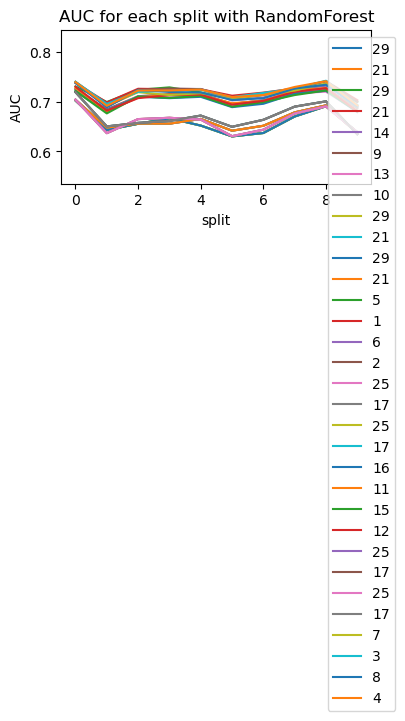

In [180]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

params =  {'m__max_depth': [5, 10], "m__min_impurity_decrease": [0.01, 0.001],
           "m__min_samples_leaf":[10, 20], "m__n_estimators":[100, 500], "m__class_weight":["balanced", None]} 
pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
RandomForest_list = ["RandomForest", best_result_df, split_results_df, results_df, params, pipe]
savedata(RandomForest_list)
AUC_split_graph(split_results_df, results_df, titre="RandomForest")
best_result_df

### Essai 15  LightGBM - balanced : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
pipe est :u0_5sm
the pipeline is : steps = [('u', undersample_0.5), ('s', scaler_transform), ('m', model)]
Nombre d'échantillon : 21588     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.747 total time=   2.6s
[CV 2/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.723 total time=   1.9s
[CV 3/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.731 total time=   2.1s
[CV 4/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.738 total time=   2.1s
[CV 5/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.732 total time=   2.4s
[CV 6/10] END m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=20;, score=0.733 total time=   2.1s
[CV 7/10] END m__learning_rate=0.1, m__max_depth=3, m__min_c

,m__learning_rate,m__max_depth,m__min_child_samples,best mean score,Control Set score
best result,0.05,3,50,0.745846,0.739816


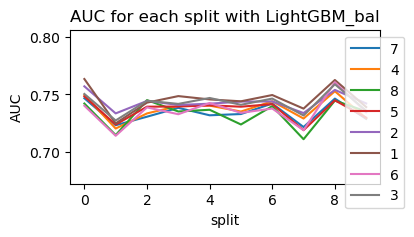

In [201]:
model = LGBMClassifier(objective="binary", n_estimators=500, class_weight="balanced")

params =  {'m__max_depth': [3, 6], "m__learning_rate": [0.1, 0.05], "m__min_child_samples":[20, 50]} 
pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_bal_list = ["LightGBM_bal", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_bal_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_bal")
best_result_df

### Essai 16  xgboost balanced : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
pipe est :u0_5sm_bal
the pipeline is : steps = [('u', undersample_0.5), ('s', scaler_transform), ('m', model)]
Nombre d'échantillon : 21588     Dimension des échantillons : 764
start GridSearchCV
weight_class_0 = 0.333 et weight_class_1 = 0.667
Nombre de classe
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=5;, score=0.772 total time=  11.9s
[CV 2/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=5;, score=0.732 total time=  12.3s
[CV 3/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=5;, score=0.741 total time=  12.7s
[CV 4/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=5;, score=0.745 total time=  13.4s
[CV 5/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=5;, score=0.747 total time=  13.1s
[CV 6/10] END m__learning_rate=0.02, m__max_depth=3, m__min_child_weight=5;, score=0.752 total time=  13

,m__learning_rate,m__max_depth,m__min_child_weight,best mean score,Control Set score
best result,0.02,3,10,0.75031,0.739992


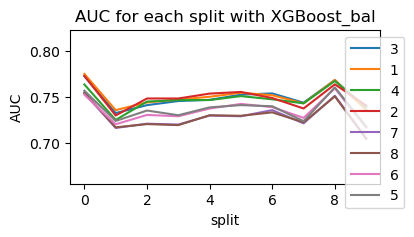

In [224]:
# https://github.com/scikit-learn/scikit-learn/issues/2879#issuecomment-276497248
# Ca ne semble pas fonctionner, les résultats sont identiques lorsque les données sont unbalanced

import warnings
model = xgb.XGBClassifier(eval_metric="logloss", n_estimators=500)
params =  {'m__max_depth': [3, 5], "m__learning_rate": [0.02, 0.005], "m__min_child_weight":[5, 10]} 

pipe = "u0_5sm_bal"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
XGBoost_bal_list = ["XGBoost_bal", best_result_df, split_results_df, results_df, params, pipe]
savedata(XGBoost_bal_list)
AUC_split_graph(split_results_df, results_df, titre="XGBoost_bal")
best_result_df

In [231]:
ModelList = get_list()
index_name=dict()
for idx, model_name in enumerate([ModelList[ii][1] for ii in range(len(ModelList))]) :
    index_name[idx]=model_name
index_name

Read file


{0: 'SVC_list_1',
 1: 'NBG_list_1',
 2: 'XGBoost',
 3: 'HistGBM',
 4: 'LightGBM',
 5: 'MLP_sklearn',
 6: 'MLP_TF',
 7: 'small_MLP_TF',
 8: 'RandomForest',
 9: 'LightGBM_bal',
 10: 'XGBoost_bal',
 11: 'NBG_ACP'}

### Essai 17  ACP + Naive Bayes : RandomUnderSampler (sampling_strategy=0.5)

shape of the X data (30840, 764)
pipe est :u0_5sm_acp
the pipeline is : undersample_0.5 | scaler_transform | acp_0.99 | model
Nombre d'échantillon : 21588     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END ............a__n_components=0.999;, score=0.597 total time=   1.4s
[CV 2/10] END ............a__n_components=0.999;, score=0.589 total time=   1.3s
[CV 3/10] END ............a__n_components=0.999;, score=0.637 total time=   1.3s
[CV 4/10] END ............a__n_components=0.999;, score=0.575 total time=   1.4s
[CV 5/10] END ............a__n_components=0.999;, score=0.605 total time=   1.2s
[CV 6/10] END ............a__n_components=0.999;, score=0.576 total time=   1.3s
[CV 7/10] END ............a__n_components=0.999;, score=0.618 total time=   1.4s
[CV 8/10] END ............a__n_components=0.999;, score=0.602 total time=   1.4s
[CV 9/10] END ............a__n_components=0.999;, score=0.598 total time=   1.

,a__n_components,best mean score,Control Set score
best result,0.4,0.625809,0.620433


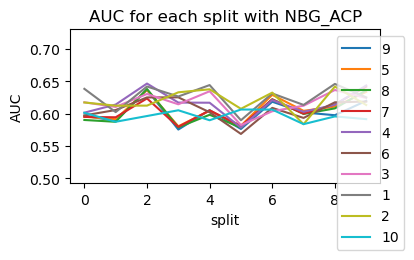

In [235]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
params = {"a__n_components" : [0.999, 0.99, 0.95, 0.9, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2]}

pipe = "u0_5sm_acp"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
NBG_ACP_list_1 = ["NBG_ACP", best_result_df, split_results_df, results_df, params, pipe]
savedata(NBG_ACP_list_1)
AUC_split_graph(split_results_df, results_df, titre="NBG_ACP")
best_result_df

### Essai 18 smallMLP_TF_drop : RandomUnderSampler (sampling_strategy=0.5)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 16)                12240     
                                                                 
 dropout_78 (Dropout)        (None, 16)                0         
                                                                 
 dense_118 (Dense)           (None, 8)                 136       
                                                                 
 dropout_79 (Dropout)        (None, 8)                 0         
                                                                 
 dense_119 (Dense)           (None, 1)                 9         
                                                                 
Total params: 12,385
Trainable params: 12,385
Non-trainable params: 0
_________________________________________________________________
None
shape of the X data (30840, 764)
pipe est :u

,m__activation_hidden_layers,m__class_weight,m__dense_size,m__dropout,best mean score,Control Set score
best result,tanh,balanced,16,0.25,0.717085,0.709922


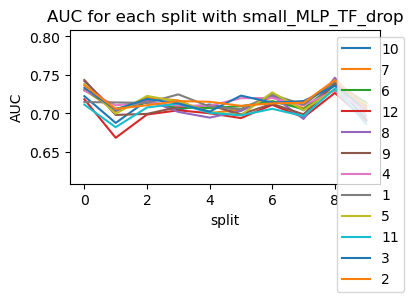

In [248]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Recall
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Input, layers

# initial hyperparameters
ndim = df_sub.shape[1]-2
# dense_1_size = int(ndim/2)
# dense_2_size = int(ndim/4)
epochs = 20

def initialize_model(ndim=ndim, dense_size=16, activation_hidden_layers="relu", dropout=0.5):   
    dense_1_size = dense_size
    dense_2_size = int(dense_size/2)
    
    model = Sequential()
    # dimension des données d'entrées qui correspond au nombre de colonnes de X_train
    model.add(Input(shape=(ndim))) 
    model.add(layers.Dense(dense_1_size, input_dim=2, activation=activation_hidden_layers))    
    model.add(layers.Dropout(dropout, seed=42))  
    model.add(layers.Dense(dense_2_size, input_dim=2, activation=activation_hidden_layers))
    model.add(layers.Dropout(dropout, seed=42))
    model.add(layers.Dense(1, activation='sigmoid'))

    # model.compile(metrics=[AUC(), Recall()], loss='binary_crossentropy')
    return model

print(initialize_model().summary())

# intialisation
model = KerasClassifier(initialize_model, epochs=epochs, batch_size=1024, verbose=0, optimizer="adam",
                metrics=[AUC(), Recall()], loss='binary_crossentropy', activation_hidden_layers="relu",
                class_weight="balanced", dense_size=128, dropout=0.5)

params = {"m__dense_size" : [16, 12],
#          "m__optimizer__learning_rate" : [.001 , .01],
          "m__activation_hidden_layers" : ["tanh"],
          "m__class_weight": [None, "balanced"],
          # "a__n_components" : [0.9, 0.7, 0.5],
          "m__dropout" : [0.5, 0.25, 0]
         } 
pipe = "u0_5sm"

best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
small_MLP_TF_drop_list = ["small_MLP_TF_drop", best_result_df, split_results_df, results_df, params, pipe]
savedata(small_MLP_TF_drop_list)
AUC_split_graph(split_results_df, results_df, titre="small_MLP_TF_drop")
best_result_df


### Essai 19 smallMLP_TF_drop_ACP : RandomUnderSampler (sampling_strategy=0.5)

In [714]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Recall
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Input, layers

# initial hyperparameters
ndim = df_sub.shape[1]-2
# dense_1_size = int(ndim/2)
# dense_2_size = int(ndim/4)
epochs = 20

def initialize_model(ndim=ndim, dense_size=16, activation_hidden_layers="relu", dropout=0.5):   
    dense_1_size = dense_size
    dense_2_size = int(dense_size/2)
    
    model = Sequential()
    # dimension des données d'entrées qui correspond au nombre de colonnes de X_train
    model.add(Input(shape=(ndim,))) 
    model.add(layers.Dense(dense_1_size, input_dim=2, activation=activation_hidden_layers))    
    model.add(layers.Dropout(dropout, seed=42))  
    model.add(layers.Dense(dense_2_size, input_dim=2, activation=activation_hidden_layers))
    model.add(layers.Dropout(dropout, seed=42))
    model.add(layers.Dense(1, activation='sigmoid'))

    # model.compile(metrics=[AUC(), Recall()], loss='binary_crossentropy')
    return model

print(initialize_model().summary())

# intialisation
model = KerasClassifier(initialize_model, epochs=epochs, batch_size=1024, verbose=0, optimizer="adam",
                metrics=[AUC(), Recall()], loss='binary_crossentropy', activation_hidden_layers="relu",
                class_weight="balanced", dense_size=128, dropout=0.5, ndim=ndim)

params = {"m__dense_size" : [15],
          "m__optimizer__learning_rate" : [.001],
          "m__activation_hidden_layers" : ["tanh"],
          "m__class_weight": ["balanced", None],
          "a__n_components" : [0.999],
          "m__dropout" : [0.08],
          "m__ndim" : [None],
          "m__epochs": [20, 30]
         } 
pipe = "u0_5sm_acp"

best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
small_MLP_TF_drop_ACP_list = ["small_MLP_TF_drop_ACP", best_result_df, split_results_df, results_df, params, pipe]
savedata(small_MLP_TF_drop_ACP_list)
AUC_split_graph(split_results_df, results_df, titre="small_MLP_TF_drop_ACP")
best_result_df

Model: "sequential_791"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2115 (Dense)          (None, 16)                12240     
                                                                 
 dropout_1402 (Dropout)      (None, 16)                0         
                                                                 
 dense_2116 (Dense)          (None, 8)                 136       
                                                                 
 dropout_1403 (Dropout)      (None, 8)                 0         
                                                                 
 dense_2117 (Dense)          (None, 1)                 9         
                                                                 
Total params: 12,385
Trainable params: 12,385
Non-trainable params: 0
_________________________________________________________________
None


ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

### Essai 20 smallMLP_TF_drop_slkb : RandomUnderSampler (sampling_strategy=0.5)

1 ['Mon, 14 Nov 2022 16:09:45', 'SVC_list_1']
2 ['Mon, 14 Nov 2022 16:10:51', 'NBG_list_1']
3 ['Mon, 14 Nov 2022 20:47:04', 'XGBoost']
4 ['Tue, 15 Nov 2022 11:18:27', 'HistGBM']
5 ['Tue, 15 Nov 2022 12:15:42', 'LightGBM']
6 ['Fri, 18 Nov 2022 21:28:13', 'MLP_sklearn']
7 ['Fri, 18 Nov 2022 21:45:28', 'MLP_TF']
8 ['Fri, 18 Nov 2022 22:21:18', 'small_MLP_TF']
9 ['Mon, 21 Nov 2022 19:19:31', 'RandomForest']
10 ['Tue, 22 Nov 2022 09:39:21', 'LightGBM_bal']
11 ['Tue, 22 Nov 2022 10:59:35', 'XGBoost_bal']
12 ['Tue, 22 Nov 2022 12:16:17', 'NBG_ACP']
13 ['Tue, 22 Nov 2022 12:46:57', 'small_MLP_TF_drop']
14 ['Wed, 23 Nov 2022 22:00:21', 'small_MLP_TF_drop_ACP']
15 ['Fri, 25 Nov 2022 09:09:38', 'small_MLP_TF_drop_slkb']
File has been read


,m__activation_hidden_layers,m__batch_size,m__class_weight,m__dense_size,m__dropout,m__epochs,m__ndim,m__optimizer__learning_rate,slkb__k,best mean score,Control Set score
best result,tanh,256,None,15,0.08,20,400,0.001,400,0.726797,0.72066


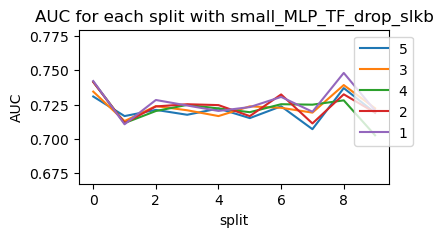

In [817]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Recall
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Input, layers

# initial hyperparameters
ndim = df_sub.shape[1]-2
# dense_1_size = int(ndim/2)
# dense_2_size = int(ndim/4)
epochs = 20

def initialize_model(ndim=ndim, dense_size=16, activation_hidden_layers="relu", dropout=0.5):   
    dense_1_size = dense_size
    dense_2_size = int(dense_size/2)
    
    model = Sequential()
    # dimension des données d'entrées qui correspond au nombre de colonnes de X_train
    model.add(Input(shape=(ndim,))) 
    model.add(layers.Dense(dense_1_size, input_dim=2, activation=activation_hidden_layers))    
    model.add(layers.Dropout(dropout, seed=42))  
    model.add(layers.Dense(dense_2_size, input_dim=2, activation=activation_hidden_layers))
    model.add(layers.Dropout(dropout, seed=42))
    model.add(layers.Dense(1, activation='sigmoid'))

    # model.compile(metrics=[AUC(), Recall()], loss='binary_crossentropy')
    return model

print(initialize_model().summary())

# intialisation
model = KerasClassifier(initialize_model, epochs=epochs, batch_size=1024, verbose=0, optimizer="adam",
                metrics=[AUC(), Recall()], loss='binary_crossentropy', activation_hidden_layers="relu",
                class_weight="balanced", dense_size=128, dropout=0.5, ndim=ndim)

params = {"m__dense_size" : [15],
          "m__optimizer__learning_rate" : [.001],
          "m__activation_hidden_layers" : ["tanh"],
          "m__class_weight": ["balanced", None],
          "slkb__k" : [500, 450, 400],
          "m__dropout" : [0.08],
          "m__ndim" : [None],
          "m__epochs": [20],
          "m__batch_size": [256] # [1024, 256]
         } 
pipe = "u0_5sm_slkb"

# np.seterr(divide='ignore', invalid='ignore')
with np.errstate(divide='ignore',invalid='ignore'):
    best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
small_MLP_TF_drop_slkb_list = ["small_MLP_TF_drop_slkb", best_result_df, split_results_df, results_df, params, pipe]
savedata(small_MLP_TF_drop_slkb_list)
AUC_split_graph(split_results_df, results_df, titre="small_MLP_TF_drop_slkb")
best_result_df

In [785]:
best_result_df

,m__activation_hidden_layers,m__batch_size,m__class_weight,m__dense_size,m__dropout,m__epochs,m__ndim,m__optimizer__learning_rate,slkb__k,best mean score,Control Set score
best result,tanh,256,None,15,0.08,20,400,0.001,400,0.726797,0.72066


# Sélection d'un modèle

(282665, 764)
(282665, 488)
ACP 99 - done in 50s
kmeans - done in 4s


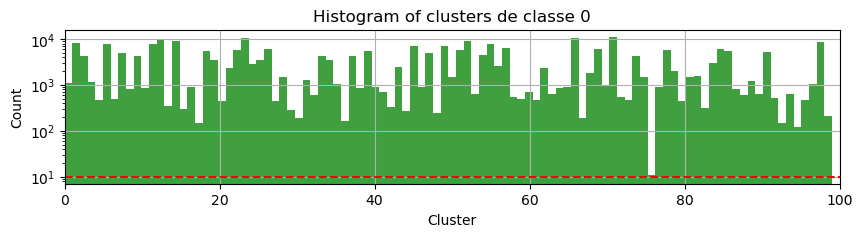

(24823, 764)
(24823, 463)
ACP 99 - done in 5s
kmeans - done in 3s


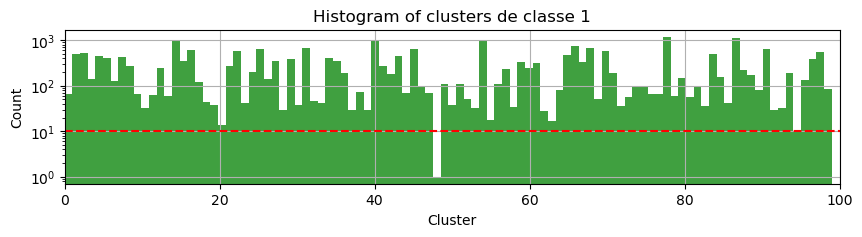

(30840, 766)


In [37]:
df_sub = reduce_samples(df, ratio=0.1)

In [121]:
ModelList = get_list()
df_tmp2 = pd.DataFrame()
# récupère fit_time de tous les modèles
for ii in range(len(ModelList)) :
    model_name = ModelList[ii][1]
    df_tmp = ModelList[ii][4]
    df_tmp = df_tmp[df_tmp["rank_test_score"]==1][["mean_fit_time", "mean_score_time"]]
    df_tmp.index=[0]
    df_tmp.rename(index={0:model_name}, inplace=True)
    df_tmp2 = pd.concat([df_tmp2, df_tmp])

# nom des listes
index_name={}
for idx, model_name in enumerate([ModelList[ii][1] for ii in range(len(ModelList))]) :  
    index_name[idx]=model_name

# concat resultat de tous les modèles
df_tmp = pd.concat([ModelList[ii][2] for ii in range(len(ModelList))], 
          ignore_index=True).rename(index=index_name)[["best mean score", "Control Set score"]]

df_score = pd.merge(df_tmp, df_tmp2, left_index=True, right_index=True)
# df_score["score_final"] = df_score["Control Set score"]+0.05/df_score.mean_fit_time + \
#                             0.0001/np.abs(df_score["Control Set score"]-df_score["best mean score"])
# df_score.sort_values("score_final", ascending=True, inplace=True)

df_score = df_score[["optim" not in model_name for model_name in df_score.index]].sort_values(by="Control Set score", ascending=False).iloc[:10]
gain_max = df_score["Control Set score"].iloc[0]-df_score["Control Set score"].iloc[-1]
df_score["inv_diff_score"] = 1/np.abs(df_score["Control Set score"]-df_score["best mean score"])
coeff_score = gain_max/df_score.inv_diff_score.max()
print(coeff_score)
df_score["inv_fit_time"] = 1/df_score.mean_fit_time
coeff_time = gain_max/df_score.inv_fit_time.max()
print(coeff_time)
df_score["score_final"]=df_score["Control Set score"]+coeff_score*df_score.inv_diff_score+coeff_time*df_score.inv_fit_time
df_score.sort_values("score_final", inplace=True)

Read file
0.00010021064316892157
0.06396693791765645


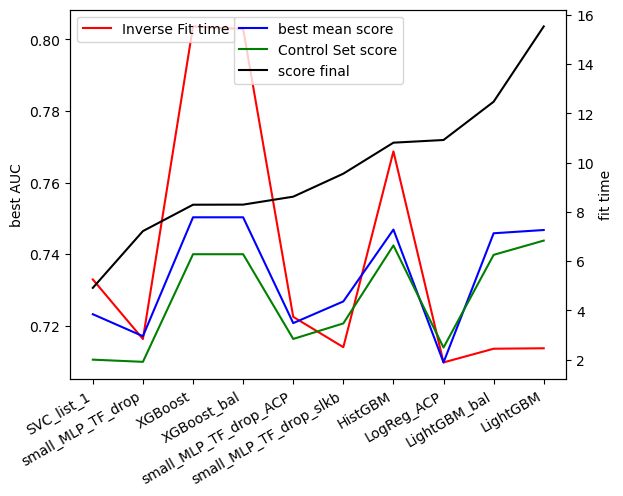

In [155]:
X = np.arange(10)# (len(ModelList))
fig = plt.figure()
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

ax = plt.subplot() # fig.add_axes([0,0,1,1])
# axt = fig.add_axes([0,0,1,2])

axt = ax.twinx()
l3, = axt.plot(X, df_score["mean_fit_time"], color = 'r',  label='Inverse Fit time')
axt.set_ylabel("fit time")
l1, = ax.plot(X, df_score["best mean score"], color = 'b',  label='best mean score')
l2, = ax.plot(X, df_score["Control Set score"], color = 'g',  label='Control Set score')
l4, = ax.plot(X, df_score.score_final, color='k', label="score final")

# plt.xticks(ticks=np.arange(len(ModelList)) ,labels=df_score.index)
plt.xticks(ticks=np.arange(10) ,labels=df_score.index)

ax.tick_params(axis='x', rotation=30)
ax.set_ylabel("best AUC")
ax.patch.set_alpha(0)
ax.set_zorder(1)
ax.legend(loc='upper center')
axt.legend(loc='upper left')

# poitionnement des labels en X par rapport à leur extrémité droite
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')

plt.show()

# Calcul des Feature Importances

### test XGBOOST

0- transformer les données pour entrer dans XGBOOST  
1- récupérer model XGBOOST optimum sans la transformation des données  
2- calculer shapley values: appliquer 'TreeExplainer' puis 'shap_values'  

In [66]:
import shap
import xgboost as xgb

dataframe = df_sub.copy()
model = xgb.XGBClassifier(eval_metric="logloss", max_depth=3, n_estimators=500, learning_rate=0.02, min_child_weight=10) 

start = time.time()
# on utilise 30% du jeu de données pour le test
test_size_ratio = 0.3

feats = [f for f in dataframe.columns if f not in ['TARGET','SK_ID_CURR']]

X_train, X_control, y_train, y_control = model_selection.train_test_split(dataframe[feats], dataframe.TARGET, test_size=test_size_ratio,
                                                                    random_state=5, shuffle=True, stratify=dataframe.TARGET)

# scaling
numeric_features = dataframe[feats].columns[dataframe[feats].nunique()>2] # categoric_features = X_train.columns[X_train.dtypes=="object"]    
scaler_transform = make_column_transformer( (preprocessing.StandardScaler(), numeric_features),
                                                      remainder = "passthrough",
                                                      verbose_feature_names_out = False)
print("shape of the X data", np.shape(scaler_transform.fit_transform(dataframe[feats])))

# define pipeline
# undersampling : sampling_strategy = ratio minority/majority
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# steps = [('u', undersample), ('s', scaler_transform), ('m', model)]   
steps = [('s', scaler_transform), ('u', undersample), ('m', model)] 

pipeline = PipelineImb(steps=steps)

time_prepa = time.time() - start

print("Temps de préparation : {}" .format(time_prepa))

print("Nombre d'échantillon : {}     Dimension des échantillons : {}" .format(X_train.shape[0], X_train.shape[1]))

# Fit model
start = time.time()
X_train_trans, y_train_trans = pipeline[:-1].fit_resample(X_train, y_train)
model.fit(X_train_trans, y_train_trans)
time_fit = time.time()-start
print("fit time : {}" .format(time_fit))

explainer = shap.TreeExplainer(model)
start = time.time()
shap_values = explainer.shap_values(X_train_trans)
time_shapvalues = time.time()-start
print("shapvalues computing time : {}" .format(time_shapvalues))


shape of the X data (30840, 764)
Temps de préparation : 1.2505607604980469
Nombre d'échantillon : 21588     Dimension des échantillons : 764


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


fit time : 14.245828628540039


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


shapvalues computing time : 1.26487135887146


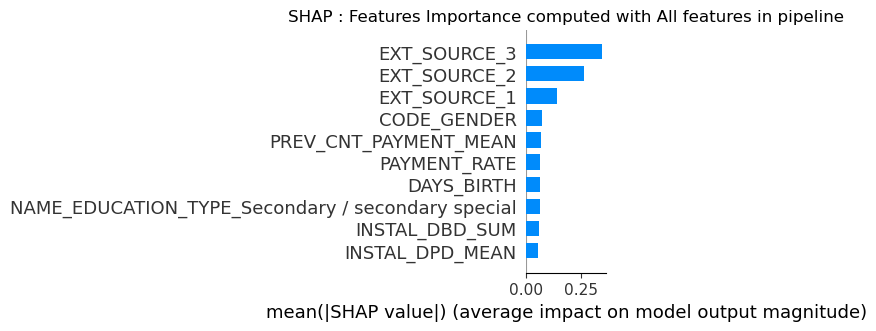

In [70]:
features_names = pipeline[:-1].get_feature_names_out()
df0 = pd.DataFrame(X_train_trans, columns=features_names)

fig = plt.figure(figsize=(8, 6))
fig.add_subplot(2, 1, 1)
shap.summary_plot(shap_values, df0,  max_display=10, plot_type="bar", plot_size=None, show=False)
plt.title("SHAP : Features Importance computed with All features in pipeline")
fig.tight_layout()  
plt.show()

In [163]:
sample_num = 0
model.predict_proba(X_train_trans[sample_num,:].reshape(1,764)), model.predict(X_train_trans[sample_num,:].reshape(1,764))

(array([[0.6733879 , 0.32661211]], dtype=float32), array([0], dtype=int64))

In [175]:
mean_proba = y_train_trans.mean(0)

from scipy.special import logit
sample_num = 2
proba = model.predict_proba(X_train_trans[sample_num,:].reshape(1,764))[0][1]
prediction = model.predict(X_train_trans[sample_num,:].reshape(1,764))
print("Numéro d'échantillon : {}, proba d'être dans la classe 1: {:2.3%}, logit(p): {:2.3%}."
      .format(sample_num, proba,  (lambda x: logit(x))(proba)) )
print("classe prédite : {}" .format(prediction))

mean_proba = y_train_trans.mean(0)
# explainer.expected_value: 
# cette valeur est la baseline des shapley values
# elle correspond à la valeur moyenne de y
# où y est le logit de cette proba obtenu avec predict_proba.  
print("Valeur de base (moyenne) estimée par SHAP : {:2.3%}, calcul logit(mean_proba): {:2.3%}" 
      .format(explainer.expected_value, (lambda p: logit(p))(mean_proba)))

X_display = pd.DataFrame(X_train_trans, columns=X_train.columns)
shap.force_plot(explainer.expected_value, shap_values[sample_num,:], X_display.iloc[sample_num,:])

Numéro d'échantillon : 2, proba d'être dans la classe 1: 52.739%, logit(p): 10.969%.
classe prédite : [1]
Valeur de base (moyenne) estimée par SHAP : -71.945%, estimation par calcul logit (p): -69.315%


## Lightgbm

#### quelques tests

In [1155]:
import re
from lightgbm import record_evaluation
from sklearn.metrics import roc_auc_score

dataframe = df_sub.copy()
model = LGBMClassifier(objective="binary", n_estimators=1000, class_weight="balanced",
                       max_depth=3, learning_rate=0.05, min_child_samples=50)

# ["average_precision", "auc", "binary_logloss"]} 
# "m__eval_metric": ["auc"], 

start = time.time()
# on utilise 30% du jeu de données pour le test
test_size_ratio = 0.3

dataframe = dataframe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
feats = [f for f in dataframe.columns if f not in ['TARGET','SK_ID_CURR']]

X_train0, X_control0, y_train0, y_control0 = model_selection.train_test_split(dataframe[feats], dataframe.TARGET, test_size=test_size_ratio,
                                                                    random_state=5, shuffle=True, stratify=dataframe.TARGET)
history={}
eval_history=record_evaluation(history)
params =  {"m__eval_set":[(X_train0, y_train0), (X_control0, y_control0)], # "m__eval_metric": ["auc"],
           "m__verbose":[500], "m__callbacks":[eval_history]} #, "m__early_stopping_rounds":[15]}

# scaling
# numeric_features = dataframe[feats].columns[dataframe[feats].nunique()>2]    
# scaler_transform = make_column_transformer( (preprocessing.StandardScaler(), numeric_features),
#                                                       remainder = "passthrough",
#                                                       verbose_feature_names_out = False)

# constant_features = dataframe[feats].columns[dataframe[feats].nunique()==1]
scaler_transform = make_column_transformer( (preprocessing.StandardScaler(), (lambda x: x.columns[x.nunique()>2])),
                                            ('drop', (lambda x: x.columns[x.nunique()==1])),
                                                      remainder = "passthrough",
                                                      verbose_feature_names_out = False)
print("shape of the X data", np.shape(scaler_transform.fit_transform(dataframe[feats])))

# define pipeline
# undersampling : sampling_strategy = ratio minority/majority
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('u', undersample), ('s', scaler_transform), ('m', model)]   
# steps = [('s', scaler_transform), ('u', undersample),  ('m', model)] 

pipeline = PipelineImb(steps=steps)

time_prepa = time.time() - start

print("Temps de préparation : {}" .format(time_prepa))

print("Nombre d'échantillon : {}     Dimension des échantillons : {}" .format(X_train.shape[0], X_train.shape[1]))

# Fit model
start = time.time()
if False :
    X_train_trans = pipeline[:-1].fit_transform(X_train, y_train) # y_train_trans  -- fit_resample
# model.fit(X_train_trans, y_train_trans)

if False :  # ca fonctionne 
    # il faut eval_set pour pouvoir calculer auc
    X_tmp, y_train_tmp = pipeline[0].fit_resample(X_train, y_train)
    X_tmp, y_test_tmp = pipeline[0].fit_resample(X_control, y_control)
    X_train_tmp = pipeline[:-1].fit_transform(X_train, y_train)
    X_test_tmp = pipeline[:-1].fit_transform(X_control, y_control)
    model.set_params(**{'verbose':-1})
    model.fit(X_train_tmp, y_train_tmp, eval_set=[(X_train_tmp, y_train_tmp), (X_test_tmp, y_test_tmp) ], eval_metric="auc", 
              early_stopping_rounds=10, callbacks= [eval_history], eval_names=["training", "test"])
    plot_metric(model, metric="auc")
    print(history['training']['auc'][-1], history['test']['auc'][-1])

        
if False :  # Ca ne fonctionne pas => fit ne voit pas eval_set, s'il est transmis avec set_parameters
    # eval_set ne peut pas être passé à set_parameters
    # ----
    X_tmp, y_train_tmp = pipeline[0].fit_resample(X_train, y_train)
    X_tmp, y_test_tmp = pipeline[0].fit_resample(X_control, y_control)
    X_train_tmp = pipeline[:-1].fit_transform(X_train, y_train)
    X_test_tmp = pipeline[:-1].fit_transform(X_control, y_control)
    model.set_params(**{'verbose':-1, 'eval_set':[(X_train_tmp, y_train_tmp), (X_test_tmp, y_test_tmp)],
                        'eval_metric':"auc", 'eval_names':["training", "test"] })
    model.fit(X_train_tmp, y_train_tmp, callbacks=[eval_history, early_stopping(10)])

if False: # it works, mais pas pertinent pour une utilisation dans la fonction evaluation
    X_tmp, y_train_tmp = pipeline[0].fit_resample(X_train, y_train)
    X_tmp, y_test_tmp = pipeline[0].fit_resample(X_control, y_control)
    X_train_tmp = pipeline[:-1].fit_transform(X_train, y_train)
    X_test_tmp = pipeline[:-1].fit_transform(X_control, y_control)
    pipeline.set_params(**{'m__verbose':-1})
    pipeline.fit(X_train0, y_train0, m__callbacks=[eval_history], m__early_stopping_rounds=10,
                 m__eval_set= [(X_train_tmp, y_train_tmp), (X_test_tmp, y_test_tmp)], m__eval_names=["training", "test"],
                 m__eval_metric="auc")
                 # m__eval_set=[(X_train0, y_train0), (X_control0, y_control0)])
    plot_metric(model, metric="auc")
    print(history['training']['auc'][-1], history['test']['auc'][-1])
        
if True: # it works
    X_train_tmp, y_train_tmp = pipeline[0].fit_resample(X_train0, y_train0)
#    X_tmp = pipeline[:-1].fit_transform(X_train0, y_train0)
    pipeline.fit(X_train0, y_train0)
    y_pred = pipeline.predict_proba(X_train_tmp)
    auc = roc_auc_score(y_train_tmp, y_pred[:,1])
    print("score sur dataset vu au training, auc : {}".format(auc))
    
    y_pred = pipeline.predict_proba(X_control0)
    auc = roc_auc_score(y_control0, y_pred[:,1])
    print("score sur dataset de controle, auc : {}".format(auc))
    
# pipeline.fit_params=params   
# pipeline.set_params(**params)
# pipeline.fit(X_train, y_train)
time_fit = time.time()-start
print("fit time : {}" .format(time_fit))

# explainer = shap.TreeExplainer(model)
# start = time.time()
# shap_values = explainer.shap_values(X_train_trans)
# time_shapvalues = time.time()-start
# print("shapvalues computing time : {}" .format(time_shapvalues))

shape of the X data (30840, 751)
Temps de préparation : 1.551194667816162
Nombre d'échantillon : 21588     Dimension des échantillons : 764
score sur dataset vu au training, auc : 0.982611478183153
score sur dataset de controle, auc : 0.7371104809711541
fit time : 4.323400974273682


### Calcul du model optimisé

In [213]:
model = LGBMClassifier(objective="binary", n_estimators=500, class_weight="balanced",
                       max_depth=3, learning_rate=0.05, min_child_samples=50)
# params =  {'m__max_depth': [3], "m__learning_rate": [0.05], "m__min_child_samples":[50]} 
params = {}
pipe = "u0_5sm"
#pipe = "u0_5sm_slkb"
model, df0, pipeline = evaluation(df_sub, model, params, pipe=pipe, grid_search=False)
# best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)

shape of the X data (61580, 755)
pipe est :u0_5sm
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
score sur dataset vu au training, auc : 0.8774516280297259
score sur dataset de controle, auc : 0.773198991210908


In [212]:
df_sub.shape

(61580, 766)

In [160]:
df0.shape

(10518, 733)

In [167]:
features_names = df0.columns[df0.columns!="TARGET"]

In [154]:
sample_num=0
proba = model.predict_proba(df0[features_names].values[sample_num,:].reshape(1,-1))[0][1]
# prediction = model.predict(X_train_tmp[sample_num,:].reshape(1,-1))
print("Numéro d'échantillon : {}, proba d'être dans la classe 1: {:2.2%}, logit(p): {:2.3f}."
  .format(sample_num, proba,  (lambda x: logit(x))(proba)) )

import joblib
joblib.dump(model, 'model_lgbm.joblib')
loaded_model = joblib.load('model_lgbm.joblib')

proba_j = loaded_model.predict_proba(df0[features_names].values[sample_num,:].reshape(1, -1))[0][1]
proba_j-proba

Numéro d'échantillon : 0, proba d'être dans la classe 1: 16.58%, logit(p): -1.615.


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


### Fonction show feature importances avec SHAP pour un échantillon

In [209]:
df0.shape

(10518, 733)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


shapvalues computing time : 1.2644727230072021
Numéro d'échantillon : 2, proba d'être dans la classe 1: 34.682%, logit(p): -0.633.
shap_value_0 (-0.258) + sum shap values (-0.375) = -0.633
classe prédite : [0]
Valeur de base estimée par SHAP : -0.26, calcul mean_proba: 33.33%
Logit de mean_proba: -0.693


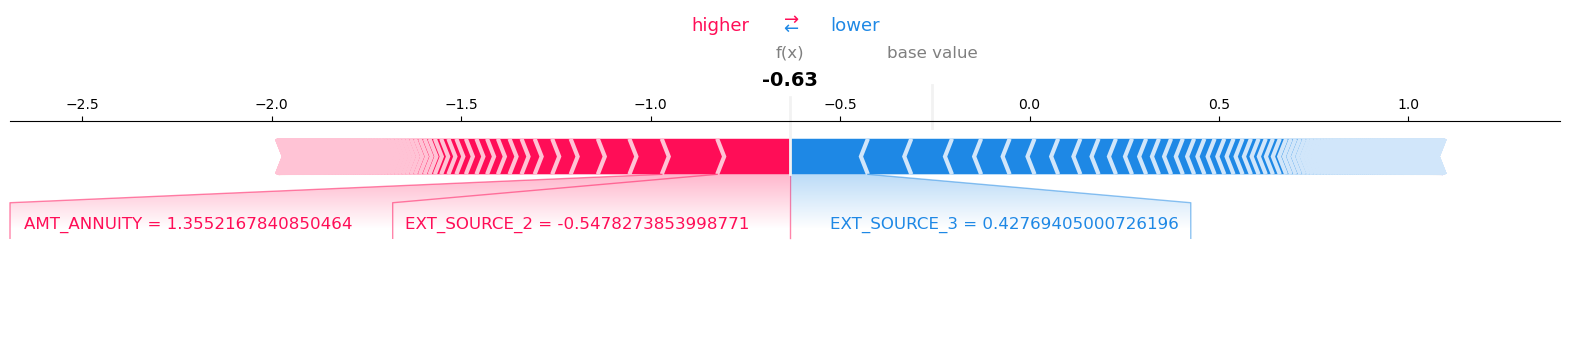

In [141]:
features_names = df0.columns[df0.columns!="TARGET"]
shap_values = show_features_importances(df0, features_names, model, sample_num=2)

### Mean of Absolute values of SHAPley values for all samples

In [122]:
shap_values_df = pd.DataFrame(shap_values,columns=features_names)
shap_values_df.abs().mean().sort_values(ascending=False)

EXT_SOURCE_3                            0.322992
EXT_SOURCE_2                            0.306107
EXT_SOURCE_1                            0.129442
AMT_ANNUITY                             0.124803
INSTAL_DPD_MEAN                         0.105273
                                          ...   
APPROVED_HOUR_APPR_PROCESS_START_MIN    0.000000
APPROVED_AMT_GOODS_PRICE_MAX            0.000000
APPROVED_AMT_DOWN_PAYMENT_MIN           0.000000
APPROVED_APP_CREDIT_PERC_VAR            0.000000
CC_NAME_CONTRACT_STATUS_Signed_MAX      0.000000
Length: 732, dtype: float64

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


shapvalues computing time : 1.0988452434539795


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


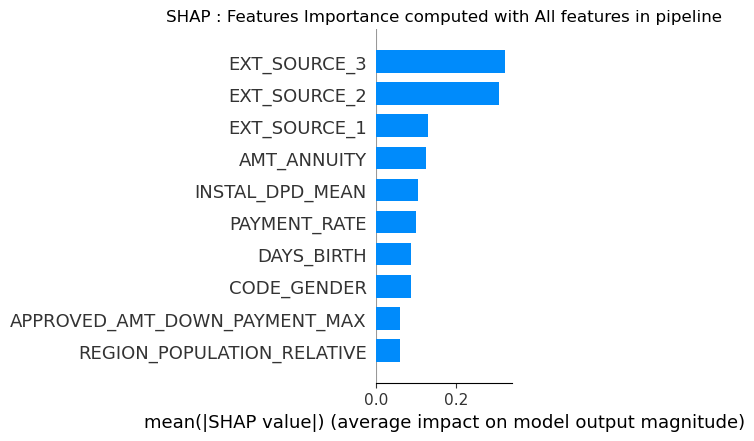

In [142]:
show_features_importances(df0, features_names, model, sample_num=None)

In [242]:
shap_values[1].shape

(732,)

In [252]:
nfeat=10
shap_values_df=pd.DataFrame(shap_values[1].reshape(1, -1),
                                columns=df0[features_names].columns) #\
                            # .sort_values(by=0, ascending=False)[:nfeat]
shap_values_df.sort_values(by=0, axis=1, ascending=False).iloc[:,:nfeat].shape

(1, 10)

In [255]:
shap_values_df=pd.DataFrame(shap_values[1],
                        index=df0[features_names].columns, columns=["value"])
shap_values_df["abs_value"] = abs(shap_values[1])
# shap_values_df.columns = ["value", "abs_value"]
            
shap_values_df.sort_values(by="abs_value", axis=0, ascending=False).iloc[:nfeat,:]

,value,abs_value
EXT_SOURCE_3,0.466546,0.466546
EXT_SOURCE_2,-0.299947,0.299947
AMT_ANNUITY,-0.220615,0.220615
BURO_AMT_CREDIT_SUM_DEBT_MEAN,0.127803,0.127803
INSTAL_DPD_MEAN,0.115125,0.115125
PREV_NAME_YIELD_GROUP_low_action_MEAN,-0.109262,0.109262
DAYS_BIRTH,-0.101730,0.101730
REG_CITY_NOT_LIVE_CITY,0.098678,0.098678
ACTIVE_DAYS_CREDIT_ENDDATE_MIN,0.092160,0.092160
EXT_SOURCE_1,0.089687,0.089687


# Création d'un dataset réduit 
...et des shapley values correspondantes.
C'est pour push sur github (et streamlit cloud): 
Github ne permet pas (en version gratuite d'uploader des fichiers trop volumineux)

Traitement de la classe 0
Dimension du dataset de la classe de départ : (7012, 732)
réduction de dimention avant clustering (7012, 442)
ACP 99 - done in 1s
Répartition du dataset dans 100 clusters
kmeans - done in 1s


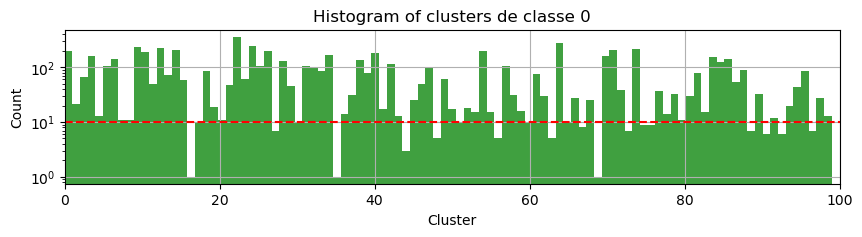

Traitement de la classe 1
Dimension du dataset de la classe de départ : (3506, 732)
réduction de dimention avant clustering (3506, 434)
ACP 99 - done in 1s
Répartition du dataset dans 100 clusters
kmeans - done in 1s


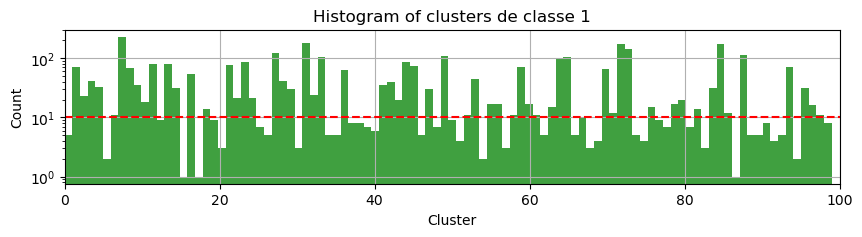

Dimension du dataset (248, 733)
écriture du dataset - done in 0s


In [206]:
df0micro = reduce_samples(df0, ratio=0.01)
print_csv=True
if print_csv:
    with timer("écriture du dataset"):
        df0micro[features_names].to_csv('home-credit-default-risk/micro_dataset.csv', index=False)

shapvalues computing time : 0.03125357627868652


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


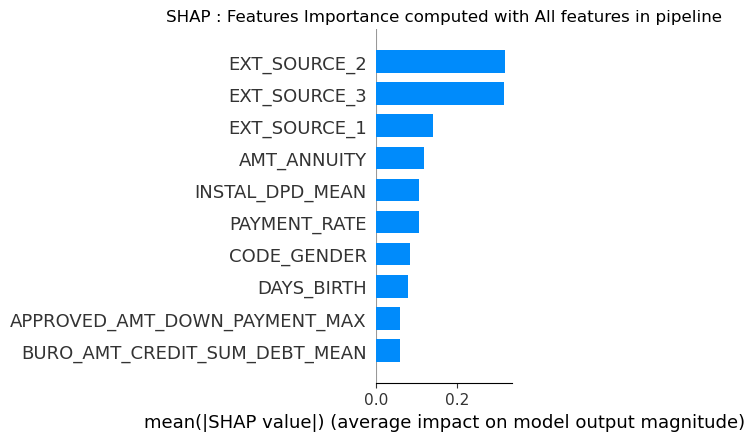

In [218]:
shap_values_micro = show_features_importances(df0micro, features_names, model, sample_num=None)
# Sur le graphe ci-dessous on voit que l'ordre de l'importance des features de df0micro 
# est légèrement décalées sur les dernières valeurs (à partir de la 7e), 
# mais globalement l'ordre de l'importance des features semble bien reproduire le dataset df0
if print_csv:
    with timer("écriture des shapley values"):
        pd.DataFrame(shap_values_micro).to_csv('home-credit-default-risk/shap_values_micro.csv', index=False)

# Fonction de Synthèse

In [411]:
# Generate a dataframe with all the parameters tested for the selected model and the best parameters and the associated result
#    select_in_model : permet de sélectionner le modèle, un type de modèle
#    select_in_pipe : permet de sélectionner un type de pipe
#    skip_in_pipe : permet de ne pas traiter un type de pipe
#    skip_in_model : permet de ne pas traiter un modèle, un type de modèle
#    fixed_param : permet de figer un paramètre
def make_synthesis_df(synthesis_type="df", select_in_model="LightGBM", select_in_pipe=None, 
                      skip_in_pipe=False, skip_in_model=[], param_name=[], height_increasement_coeff=1, fixed_param=[]) :
    # select_in_model can be string or a list of string``` 
    ModelList = get_list()            
    optim_synthesis_df = pd.DataFrame()
    min_score_for_param = 1
    max_score_for_param = 0
    df_one_param_some_values_list = []
    model_name_list=[]
    for list_1_model in ModelList : # récupération de tout les résultats du modèles
        model_name = list_1_model[1]

        # transforme en liste les string pour faciliter la suite du traitement
        if type(skip_in_model)!=list:
            skip_in_model=[skip_in_model]
        if type(select_in_model)!=list:
            select_in_model=[select_in_model]
        if type(param_name)!=list:
            param_name=[param_name]      
        
        if list_1_model[6]==skip_in_pipe : continue
        
        skip=False
        for shortword in skip_in_model:
            if shortword in model_name: skip=True
        if skip : continue
        
        if select_in_pipe :
            if list_1_model[6]!=select_in_pipe : continue

        # création des tableaux
        for selected_model in select_in_model:
            if selected_model in model_name:

                new_df = make_model_synthesis_df(list_1_model)
                optim_synthesis_df = pd.concat([optim_synthesis_df, new_df])

                # vérifie si la liste param_name correspond à des paramètres dans le modèle 
                for param_name_token in param_name:
                    
                    if "param_" not in param_name_token : raise ValueError('param_name should start with "param_".')
                    if param_name_token not in list_1_model[4].columns: continue
 
                    model_name_list.append(model_name)
                    
                    # Crée des boxplot pour comparer l'effet d'un paramètre sur les résultats
                    if synthesis_type=="graph":

                        df_tmp = list_1_model[4]
                        df_tmp_split = list_1_model[3]
                        df_one_param_some_values = pd.DataFrame()

                        # for param_name_token in param_name:
                        for param_value in df_tmp[param_name_token].values :

                            # récupère la liste des Splits score pour une valeur de paramètre
                            if fixed_param:
                                param_fixed = list(fixed_param.keys())[0]
                                list_index = list(df_tmp[(df_tmp[param_name_token]==param_value) & 
                                                         (df_tmp[param_fixed]==fixed_param[param_fixed])].index)
                                if not list_index : raise ValueError("Il semble que la valeur fixée pour le paramètre n'existe pas.")
                            else : list_index = list(df_tmp[df_tmp[param_name_token]==param_value].index)
                            
                            # si la valeur du paramètre est None il faut un traitement spécial
                            if not param_value :
                                if fixed_param:
                                    list_index = list(df_tmp[(df_tmp[param_name_token].isna()) &
                                                              (df_tmp[param_fixed]==fixed_param[param_fixed])].index)
                                else : list_index = list(df_tmp[df_tmp[param_name_token].isna()].index)
                                
                            df_tmp_selected = df_tmp_split[df_tmp_split.index.isin(list_index)]
                            # 
                            df_one_param_some_values[param_name_token+"="+str(round(param_value,2))] = \
                                                    pd.concat([df_tmp_selected[col] for col in df_tmp_selected.columns], ignore_index=True)
                        
                            
                        # les dataframes "df_one_param_some_values" contiennent la liste des scores pour chaque valeur de paramètre
                        df_one_param_some_values_list.append(df_one_param_some_values)
                        
                        # Met à jour les valeurs max et min des score pour permettre d'avoir la même échelle pour tous les graphes
                        if df_one_param_some_values.values.min() < min_score_for_param : min_score_for_param=df_one_param_some_values.values.min()
                        if df_one_param_some_values.values.max() > max_score_for_param : max_score_for_param=df_one_param_some_values.values.max()

    if synthesis_type=="graph":
        fig=plt.figure(figsize=(3,len(model_name_list)*height_increasement_coeff))
        ax=[]

        for idx, model_name in enumerate(model_name_list) :

            df_one_param_some_values = df_one_param_some_values_list[idx]
            
            fig.add_subplot(len(model_name_list),1, (idx+1))

            ax = df_one_param_some_values.boxplot(vert=False, widths=0.5)        
            ax.set_xlim(min_score_for_param, max_score_for_param)
            ax.set_title(model_name+" \n "+param_name_token, y=0., x=1.5) # ax.set_title('Manual y', y=1.0, pad=-14)
            plt.draw() # to get the labels with get_xticklabels, it is necessary to draw the plot before
            labels = ax.get_xticklabels(which='both')
            ax.set_xticklabels("")
            # plt.show()
        ax.set_xlabel("score")
        ax.set_xticklabels(labels)
        # fig.tight_layout()
        plt.show()
        
    if synthesis_type=="df" :
        optim_synthesis_df = optim_synthesis_df.T
        # move best_result in 1rst raw 
        optim_synthesis_df["reorder"]=np.arange(len(optim_synthesis_df))
        optim_synthesis_df.loc["best_result","reorder"]=-1
        optim_synthesis_df.loc["best_parameters","reorder"]=-2
        optim_synthesis_df.loc["model_name","reorder"]=-3
        optim_synthesis_df.sort_values(by="reorder", inplace=True)
        optim_synthesis_df.drop("reorder", axis=1, inplace=True)

        pd.set_option('display.max_colwidth', None)
        return optim_synthesis_df

# function used in make_synthesis_df, select parameters and corresponding values  
def make_model_synthesis_df(list_1_model):
    list_param_not_used = []
    new_df=pd.DataFrame(index=[list_1_model[6]])
    # Liste des paramètres pouvant être utilisé par grid_search
    for key in list(list_1_model[5].keys()) :
        new_df[key]=[list_1_model[5][key]]
        # Récupère la liste des paramètres qui n'ont pas subi de variation lors du grid search
        if len(new_df[key].values[0])<2 :
            list_param_not_used.append(key)
    best = str( round(list_1_model[2]["Control Set score"].values[0], 3))
    err = str( round((list_1_model[2]["Control Set score"].values - 
                      list_1_model[2]["best mean score"].values)[0], 3))
    resultat = best + " +/- " + err
    new_df["best_result"] = resultat
    best_parameters_ = "{"
    for parameter_name in [param_name for param_name in list_1_model[2].columns 
                                if param_name not in ["best mean score","Control Set score"]] :
        # best_parameters_[parameter_name] = list_1_model[2][parameter_name].values[0]
        if parameter_name not in list_param_not_used :
            tmp = str(parameter_name) + " : " + str(list_1_model[2][parameter_name].values[0]) + ", "
            best_parameters_ = best_parameters_ + tmp
    # récupération des meilleurs paramètres
    best_parameters_ = best_parameters_[:-2] +"}"
    new_df["best_parameters"] = best_parameters_
    new_df["model_name"] = list_1_model[1]
    return new_df

# Optimisation LightGBM avec score : AUC (dataset_ratio=0.2)

In [161]:
(df_sub_02.TARGET==1).sum()

5009

Traitement de la classe 0
Dimension du dataset de la classe de départ : (282665, 764)
réduction de dimention avant clustering (282665, 488)
ACP 99 - done in 54s
Répartition du dataset dans 100 clusters
kmeans - done in 4s


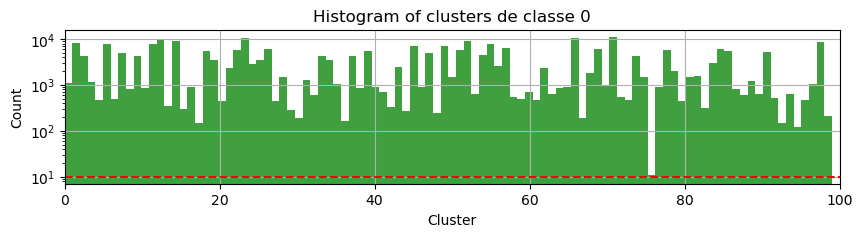

Traitement de la classe 1
Dimension du dataset de la classe de départ : (24823, 764)
réduction de dimention avant clustering (24823, 463)
ACP 99 - done in 4s
Répartition du dataset dans 100 clusters
kmeans - done in 3s


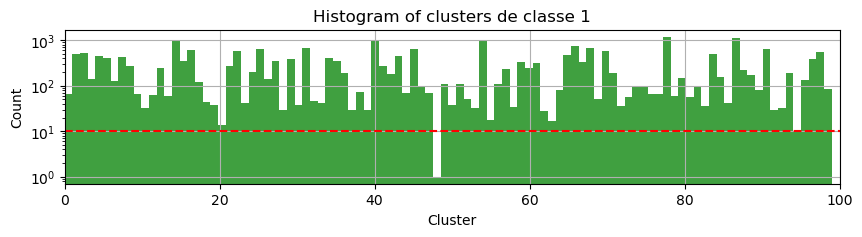

Dimension du dataset (61580, 766)


In [160]:
df_sub_02 = reduce_samples(df, ratio=0.2)

On fixe:
- learning_rate = on testera d'autres learning rate sur la config d'hyperparametre optimum
- min_child_samples : qu'on adaptera en cas de sur apprentissage
- class_weight : on retestera autour de la config optimum

## LightGBM Optim 1

shape of the X data (61580, 755)
pipe est :u0_5sm_slkb
the pipeline is : ['undersample_0.5', 'scaler_transform', 'slkb', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=50, m__n_estimators=400, slkb__k=350;, score=0.760 total time=   2.8s
[CV 2/10] END m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=50, m__n_estimators=400, slkb__k=350;, score=0.748 total time=   2.3s
[CV 3/10] END m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=50, m__n_estimators=400, slkb__k=350;, score=0.765 total time=   2.4s
[CV 4/10] END m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=50, m__n_estimators=400, slkb__k=350;, score=0.741 total time=   2.4s
[CV 5/10] END m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=50, m__n_estimators=400, slkb__k=350;, score=0.740 tota

,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,slkb__k,best mean score,Control Set score
best result,0.05,3,50,400,700,0.75535,0.771864


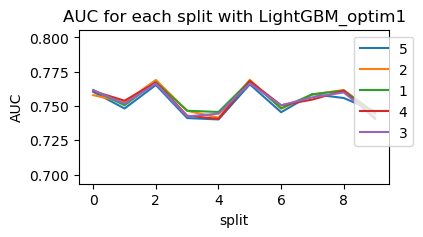

In [20]:
model = LGBMClassifier(objective="binary", class_weight="balanced")

params =  {'m__max_depth': [3, 6, 9], "m__learning_rate": [0.05], "m__min_child_samples":[50],
           "slkb__k":[350, 500, 700], "m__n_estimators":[400, 800]} 
pipe = "u0_5sm_slkb"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_optim1_list = ["LightGBM_optim1", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optim1_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optim1")
best_result_df

## LightGBM Optim 2

shape of the X data (61580, 755)
pipe est :u0_5sm
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.761 total time=   2.8s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.759 total time=   3.0s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.768 total time=   2.7s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.741 total time=   3.1s
[CV 5/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,best mean score,Control Set score
best result,balanced,0.05,3,100,400,0.758422,0.773708


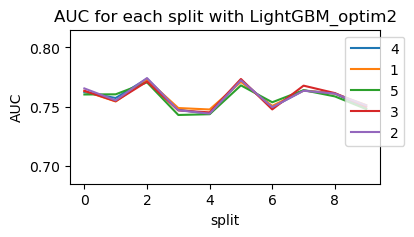

In [23]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3], "m__learning_rate": [0.1, 0.05, 0.01], "m__min_child_samples":[200, 100, 50],
           "m__n_estimators":[400], "m__class_weight":["balanced", None]} 
pipe = "u0_5sm"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_optim2_list = ["LightGBM_optim2", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optim2_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optim2")
best_result_df

## LightGBM Optim 3

shape of the X data (61580, 755)
pipe est :u0_25sm_smote0_5
the pipeline is : ['undersample_0.25', 'scaler_transform', 'smote0_5', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=2, sm__sampling_strategy=0.7;, score=0.763 total time=   6.2s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=2, sm__sampling_strategy=0.7;, score=0.754 total time=   6.7s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=2, sm__sampling_strategy=0.7;, score=0.774 total time=   6.6s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,sm__k_neighbors,sm__sampling_strategy,best mean score,Control Set score
best result,None,0.05,3,100,400,5,0.3,0.760722,0.778642


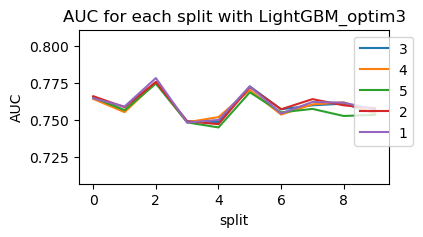

In [53]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3], "m__learning_rate": [0.05], "m__min_child_samples":[100],
           "m__n_estimators":[400], "m__class_weight":["balanced", None], "sm__sampling_strategy" : [0.7, 0.3],
           "sm__k_neighbors":[2, 5]} 

pipe = "u0_25sm_smote0_5"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_optim3_list = ["LightGBM_optim3", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optim3_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optim3")
best_result_df

## LightGBM Optim 4

shape of the X data (61580, 755)
pipe est :u0_25sm_adasyn0_5
the pipeline is : ['undersample_0.25', 'scaler_transform', 'adasyn0_5', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END Ad__n_neighbors=2, Ad__sampling_strategy=minority, m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400;, score=0.760 total time=   9.7s
[CV 2/10] END Ad__n_neighbors=2, Ad__sampling_strategy=minority, m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400;, score=0.753 total time=   8.8s
[CV 3/10] END Ad__n_neighbors=2, Ad__sampling_strategy=minority, m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400;, score=0.775 total time=   9.5s
[CV 4/10] END Ad__n_neighbors=2, Ad__sampling_strategy=minority, m__

,Ad__n_neighbors,Ad__sampling_strategy,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,best mean score,Control Set score
best result,2,minority,None,0.05,3,100,400,0.756054,0.770605


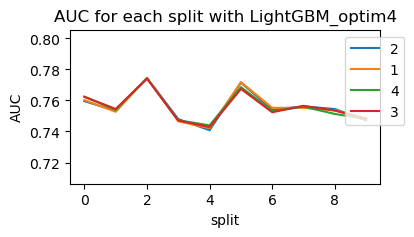

In [46]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3], "m__learning_rate": [0.05], "m__min_child_samples":[100],
           "m__n_estimators":[400], "m__class_weight":["balanced", None], "Ad__sampling_strategy" : ['minority'],
           "Ad__n_neighbors":[2, 5]} 

pipe = "u0_25sm_adasyn0_5"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_optim4_list = ["LightGBM_optim4", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optim4_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optim4")
best_result_df

## LightGBM Optim 5

shape of the X data (61580, 755)
pipe est :uTL_scaler_smote0_5
the pipeline is : ['undersampleTL_0.25', 'scaler_transform', 'smote0_5', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=5, sm__sampling_strategy=0.3;, score=0.763 total time= 1.0min
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=5, sm__sampling_strategy=0.3;, score=0.757 total time= 1.1min
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=5, sm__sampling_strategy=0.3;, score=0.781 total time= 1.2min
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,sm__k_neighbors,sm__sampling_strategy,best mean score,Control Set score
best result,None,0.05,3,100,400,5,0.3,0.759355,0.773131


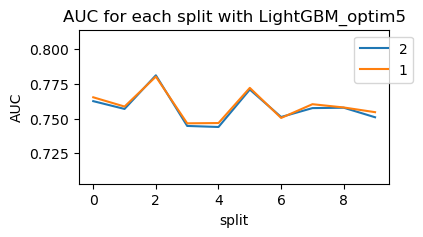

In [59]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3], "m__learning_rate": [0.05], "m__min_child_samples":[100],
           "m__n_estimators":[400], "m__class_weight":["balanced", None], "sm__sampling_strategy" : [0.3],
           "sm__k_neighbors":[5]} 

pipe = "uTL_scaler_smote0_5"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_optim5_list = ["LightGBM_optim5", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optim5_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optim5")
best_result_df

## LightGBM Optim 6

shape of the X data (61580, 755)
pipe est :uNM_scaler_smote0_5
the pipeline is : ['undersampleNM_0.25', 'scaler_transform', 'smote0_5', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=5, sm__sampling_strategy=0.3, u__n_neighbors=3, u__sampling_strategy=0.1;, score=0.736 total time=  15.2s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=5, sm__sampling_strategy=0.3, u__n_neighbors=3, u__sampling_strategy=0.1;, score=0.733 total time=  15.1s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=100, m__n_estimators=400, sm__k_neighbors=5, sm__sampling_strategy=0.3, u__n_neighbors=3, u__sam

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,sm__k_neighbors,sm__sampling_strategy,u__n_neighbors,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.05,3,100,400,5,0.3,3,0.1,0.730585,0.735439


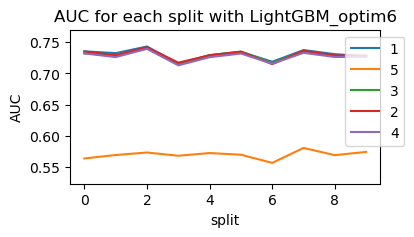

In [60]:
model = LGBMClassifier(objective="binary")
params =  {'m__max_depth': [3], "m__learning_rate": [0.05], "m__min_child_samples":[100],
           "m__n_estimators":[400], "m__class_weight":["balanced", None], "u__sampling_strategy":[0.1, 0.25],
           "u__n_neighbors":[3,5], "sm__sampling_strategy" : [0.3], "sm__k_neighbors":[5]} 

pipe = "uNM_scaler_smote0_5"
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, pipe=pipe)
    
LightGBM_optim6_list = ["LightGBM_optim6", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optim6_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optim6")
best_result_df

TODO
- test avec différentes valeurs de smote : autour du meilleur set d'hyperparamètres ci-dessus
- idem avec Adasyn
- idem avec undersampling
    - Near Miss Undersampling
    - Tomek Links (à l'interface entre les 2 classes suppression des samples majoritaires plus proches voisins d'un sample minoritaire.)


## Synthèse de Optim

In [265]:
make_synthesis_df(synthesis_type="df", skip_in_pipe="u0_5sm")

Read file


,u0_5sm_slkb,u0_25sm_adasyn0_5,u0_25sm_smote0_5,uTL_scaler_smote0_5,uNM_scaler_smote0_5,u0_25sm_smote0_5,u0_25sm_smote0_5
model_name,LightGBM_optim1,LightGBM_optim4,LightGBM_optim3,LightGBM_optim5,LightGBM_optim6,LightGBM_optimFtwo_3,LightGBM_optimFtwo_5
best_parameters,"{m__max_depth : 3, m__n_estimators : 400, slkb__k : 700}","{Ad__n_neighbors : 2, m__class_weight : None}","{m__class_weight : None, sm__k_neighbors : 5, sm__sampling_strategy : 0.3}",{m__class_weight : None},"{m__class_weight : balanced, u__n_neighbors : 3, u__sampling_strategy : 0.1}","{m__max_depth : 5, sm__sampling_strategy : 0.6}","{m__learning_rate : 0.03, sm__sampling_strategy : 0.55}"
best_result,0.772 +/- 0.017,0.771 +/- 0.015,0.779 +/- 0.018,0.773 +/- 0.014,0.735 +/- 0.005,0.442 +/- 0.019,0.443 +/- 0.0
m__max_depth,"[3, 6, 9]",[3],[3],[3],[3],"[3, 5]",[5]
m__learning_rate,[0.05],[0.05],[0.05],[0.05],[0.05],[0.05],"[0.05, 0.03]"
m__min_child_samples,[50],[100],[100],[100],[100],[300],[400]
slkb__k,"[350, 500, 700]",NaN,NaN,NaN,NaN,NaN,NaN
m__n_estimators,"[400, 800]",[400],[400],[400],[400],[400],[500]
m__class_weight,NaN,"[balanced, None]","[balanced, None]","[balanced, None]","[balanced, None]",[balanced],[balanced]
Ad__sampling_strategy,NaN,[minority],NaN,NaN,NaN,NaN,NaN


In [266]:
make_synthesis_df(synthesis_type="df", select_in_pipe="u0_5sm", skip_in_model="optimFtwo")

Read file


,u0_5sm,u0_5sm,u0_5sm
model_name,LightGBM,LightGBM_bal,LightGBM_optim2
best_parameters,"{m__learning_rate : 0.05, m__max_depth : 3, m__min_child_samples : 50}","{m__learning_rate : 0.05, m__max_depth : 3, m__min_child_samples : 50}","{m__class_weight : balanced, m__learning_rate : 0.05, m__min_child_samples : 100}"
best_result,0.744 +/- -0.003,0.74 +/- -0.006,0.774 +/- 0.015
m__max_depth,"[3, 6]","[3, 6]",[3]
m__learning_rate,"[0.1, 0.05]","[0.1, 0.05]","[0.1, 0.05, 0.01]"
m__min_child_samples,"[20, 50]","[20, 50]","[200, 100, 50]"
m__n_estimators,NaN,NaN,[400]
m__class_weight,NaN,NaN,"[balanced, None]"


In [313]:
ModelList = get_list()
index_name={}
for idx, model_name in enumerate([ModelList[ii][1] for ii in range(len(ModelList))]) :  
    index_name[idx]=model_name
    # parameters = ModelList[idx][4]
    
df_tmp = pd.concat([ModelList[ii][2] for ii in range(len(ModelList))], 
                    ignore_index=True).rename(index=index_name)[["best mean score", "Control Set score"]]
df_tmp

Read file


,best mean score,Control Set score
SVC_list_1,0.723230,0.710529
NBG_list_1,0.538989,0.520655
XGBoost,0.750310,0.739992
HistGBM,0.746879,0.742444
LightGBM,0.746755,0.743797
MLP_sklearn,0.694868,0.675980
MLP_TF,0.695042,0.679221
small_MLP_TF,0.716359,0.706245
RandomForest,0.721406,0.701750
LightGBM_bal,0.745846,0.739816


Read file


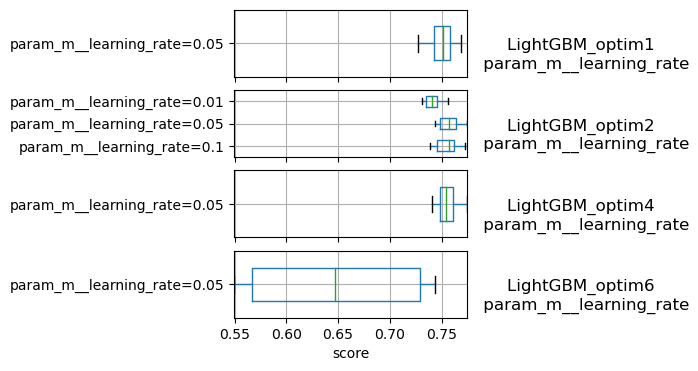

In [362]:
params = ["param_m__learning_rate"]
select_in_model =["LightGBM_optim1", "LightGBM_optim2", 
                 "LightGBM_optim4", "LightGBM_optim6"]
make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, param_name=params)

Read file


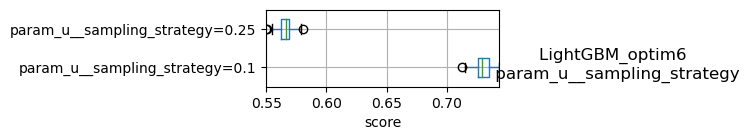

In [367]:
params = ["param_u__sampling_strategy"]
select_in_model =["LightGBM_optim1", "LightGBM_optim2", "LightGBM_optim3", 
                 "LightGBM_optim4", "LightGBM_optim5", "LightGBM_optim6"]
make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, param_name=params)

Read file


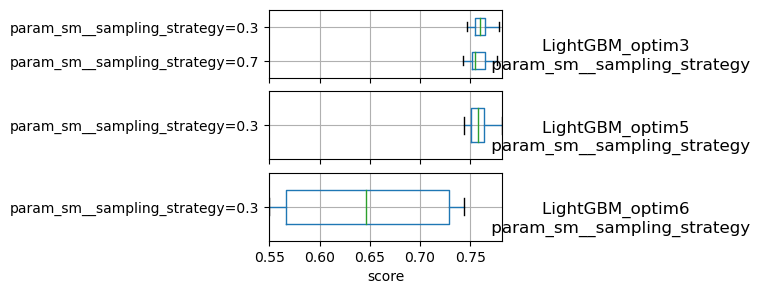

In [365]:
params = ["param_sm__sampling_strategy"]
select_in_model =["LightGBM_optim1", "LightGBM_optim2", "LightGBM_optim3", 
                 "LightGBM_optim4", "LightGBM_optim5", "LightGBM_optim6"]
make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, param_name=params)

# Optimisation LightGBM avec score : Ftwo_score (dataset_ratio=0.2)
Utilisation du $F_\beta$ score avec $\beta=2$

## LightGBM OptimFtwo 1 
même paramétrage que 'LightGBM Optim 2'

shape of the X data (61580, 755)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.414 total time=   3.3s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.415 total time=   3.0s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.430 total time=   2.8s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.1, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.399 total time=   2.8s
[CV 5/10] END m__class_weight=balanced, m__learning

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,best mean score,Control Set score
best result,balanced,0.05,3,200,400,0.427078,0.438294


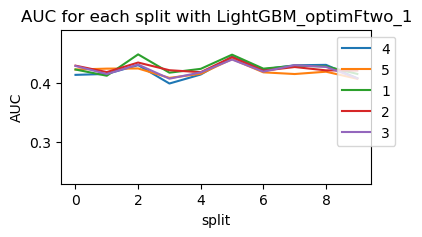

In [456]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3], "m__learning_rate": [0.1, 0.05, 0.01], "m__min_child_samples":[200, 100, 50],
           "m__n_estimators":[400], "m__class_weight":["balanced", None]} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_1_list = ["LightGBM_optimFtwo_1", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_1_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_1")
best_result_df

## LightGBM OptimFtwo 2

shape of the X data (61580, 755)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.423 total time=   2.8s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.412 total time=   2.8s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.449 total time=   2.7s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=200, m__n_estimators=400;, score=0.417 total time=   2.9s
[CV 5/10] END m__class_weight=balanced, m__lear

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,best mean score,Control Set score
best result,balanced,0.05,5,300,400,0.427409,0.440771


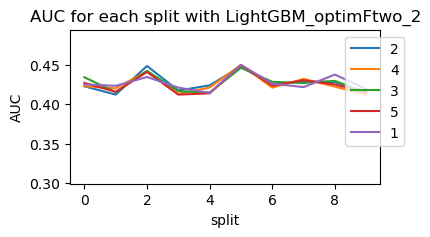

In [457]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3, 5], "m__learning_rate": [0.05], "m__min_child_samples":[200, 300],
           "m__n_estimators":[400, 600], "m__class_weight":["balanced", None]} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_2_list = ["LightGBM_optimFtwo_2", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_2_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_2")
best_result_df

## LightGBM OptimFtwo 2u

In [632]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5], "m__learning_rate": [0.05], "m__min_child_samples":[300],
           "m__n_estimators":[400], "m__class_weight":["balanced", None], "u__sampling_strategy":[0.2, 0.5]} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_2u_list = ["LightGBM_optimFtwo_2u", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_2u_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_2u")
best_result_df

## LightGBM OptimFtwo 2ub

shape of the X data (61580, 755)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__sampling_strategy=0.3;, score=0.429 total time=   4.9s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__sampling_strategy=0.3;, score=0.422 total time=   5.2s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__sampling_strategy=0.3;, score=0.430 total time=   5.3s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.05,5,300,400,0.5,0.427409,0.440771


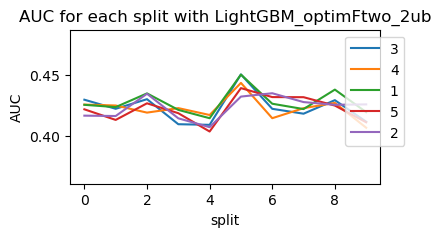

In [638]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5], "m__learning_rate": [0.05], "m__min_child_samples":[300],
           "m__n_estimators":[400], "m__class_weight":["balanced"], "u__sampling_strategy":np.linspace(0.3, 1., 8)} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_2ub_list = ["LightGBM_optimFtwo_2ub", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_2ub_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_2ub")
best_result_df

## LightGBM OptimFtwo 3

shape of the X data (61580, 755)
pipe est :u0_25sm_smote0_5
the pipeline is : ['undersample_0.25', 'scaler_transform', 'smote0_5', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=300, m__n_estimators=400, sm__sampling_strategy=0.6, u__sampling_strategy=0.5;, score=0.428 total time=   3.7s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=300, m__n_estimators=400, sm__sampling_strategy=0.6, u__sampling_strategy=0.5;, score=0.421 total time=   3.6s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=3, m__min_child_samples=300, m__n_estimators=400, sm__sampling_strategy=0.6, u__sampling_strategy=0.5;, score=0.424 total time=   3.5s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,sm__sampling_strategy,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.05,5,300,400,0.6,0.5,0.423167,0.44225


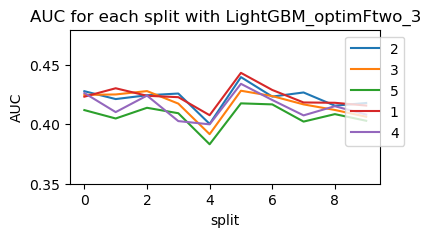

In [663]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [3, 5], "m__learning_rate": [0.05], "m__min_child_samples":[300],
           "m__n_estimators":[400], "m__class_weight":["balanced"], "sm__sampling_strategy" : [0.6, 0.7, 0.8],
           "u__sampling_strategy":[0.5]} 
pipe = "u0_25sm_smote0_5"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_3_list = ["LightGBM_optimFtwo_3", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_3_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_3")
best_result_df

## Synthesis 

In [670]:
make_synthesis_df(synthesis_type="df", select_in_model="LightGBM_optimFtwo")

Read file


,u0_5sm,u0_5sm,u0_25sm_smote0_5,u0_5sm,u0_5sm
model_name,LightGBM_optimFtwo_1,LightGBM_optimFtwo_2,LightGBM_optimFtwo_3,LightGBM_optimFtwo_2u,LightGBM_optimFtwo_2ub
best_parameters,"{m__class_weight : balanced, m__learning_rate : 0.05, m__min_child_samples : 200}","{m__class_weight : balanced, m__max_depth : 5, m__min_child_samples : 300, m__n_estimators : 400}","{m__max_depth : 5, sm__sampling_strategy : 0.6}","{m__class_weight : balanced, u__sampling_strategy : 0.5}",{u__sampling_strategy : 0.5}
best_result,0.438 +/- 0.011,0.441 +/- 0.013,0.442 +/- 0.019,0.441 +/- 0.013,0.441 +/- 0.013
m__max_depth,[3],"[3, 5]","[3, 5]",[5],[5]
m__learning_rate,"[0.1, 0.05, 0.01]",[0.05],[0.05],[0.05],[0.05]
m__min_child_samples,"[200, 100, 50]","[200, 300]",[300],[300],[300]
m__n_estimators,[400],"[400, 600]",[400],[400],[400]
m__class_weight,"[balanced, None]","[balanced, None]",[balanced],"[balanced, None]",[balanced]
sm__sampling_strategy,NaN,NaN,"[0.6, 0.7, 0.8]",NaN,NaN
u__sampling_strategy,NaN,NaN,[0.5],"[0.2, 0.5]","[0.3, 0.39999999999999997, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 1.0]"


Read file


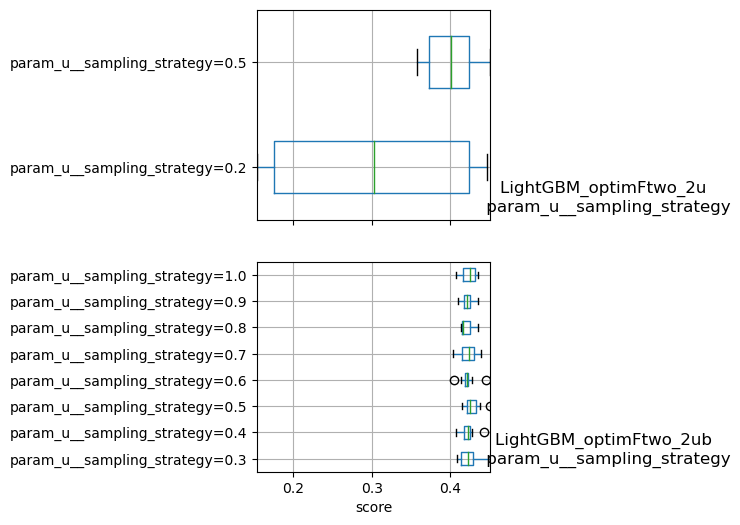

In [385]:
select_in_model = ["LightGBM_optimFtwo_2u"]
make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, 
                  param_name="param_u__sampling_strategy", height_increasement_coeff=3)

Read file


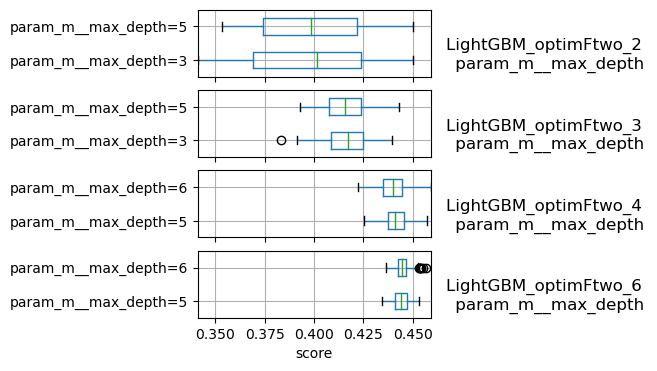

In [278]:
select_in_model = ["LightGBM_optimFtwo_2", "LightGBM_optimFtwo_3", "LightGBM_optimFtwo_4", "LightGBM_optimFtwo_6"]
make_synthesis_df(synthesis_type="graph", select_in_model=select_in_model, param_name="param_m__max_depth", 
                  skip_in_model="optimFtwo_2u")

Read file


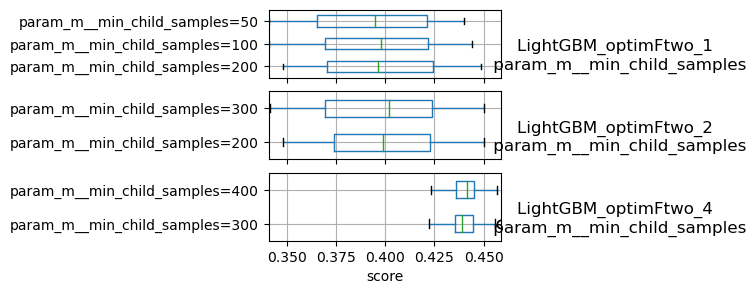

In [413]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo", param_name="param_m__min_child_samples",
                  skip_in_model=["optimFtwo_2u", "optimFtwo_3", "optimFtwo_5", "optimFtwo_6"], fixed_param={"param_m__learning_rate": 0.05})

Read file


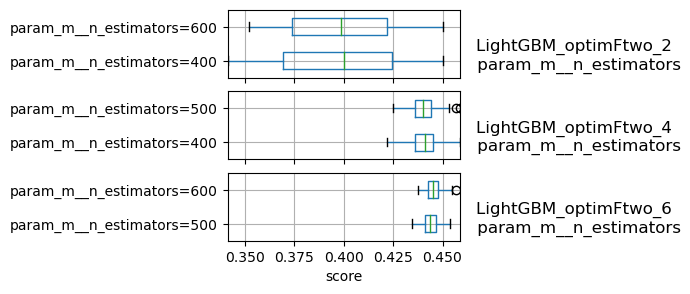

In [203]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo", param_name="param_m__n_estimators",
                  skip_in_model=["optimFtwo_2u", "optimFtwo_3", "optimFtwo_1", "optimFtwo_5"])

### check accuracy and recall

In [741]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5], "m__learning_rate": [0.05], "m__min_child_samples":[300],
           "m__n_estimators":[400], "m__class_weight":["balanced"]} 
pipe = "u0_5sm"
scoring_param='precision'
best_result_df, split_results_df, results_df = evaluation(df_sub_02, model, params, scoring_param=scoring_param, pipe=pipe) 
best_result_df

shape of the X data (61580, 755)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.180 total time=   4.0s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.178 total time=   4.2s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.188 total time=   4.5s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.178 total time=   4.2s
[CV 5/10] END m__class_weight=balanced, m__learni

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,best mean score,Control Set score
best result,balanced,0.05,5,300,400,0.181784,0.185982


In [743]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5], "m__learning_rate": [0.05], "m__min_child_samples":[300],
           "m__n_estimators":[400], "m__class_weight":["balanced"]} 
pipe = "u0_5sm"
scoring_param='recall'
best_result_df, split_results_df, results_df = evaluation(df_sub_02, model, params, scoring_param=scoring_param, pipe=pipe) 
best_result_df

shape of the X data (61580, 746)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.650 total time=   4.9s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.662 total time=   4.3s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.659 total time=   4.5s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400;, score=0.628 total time=   4.1s
[CV 5/10] END m__class_weight=balanced, m__learni

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,best mean score,Control Set score
best result,balanced,0.05,5,300,400,0.650314,0.619428


In [745]:
from sklearn.dummy import DummyClassifier

# model to be tested
model = DummyClassifier(random_state=42)
params = {'m__strategy': ["stratified"] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())
pipe = "u0_5sm"
scoring_param='precision'
best_result_df, split_results_df, results_df= evaluation(df_sub_02, model, params, scoring_param=scoring_param, pipe=pipe)
best_result_df

(123078, 766)
0    113105
1      9973
Name: TARGET, dtype: int64
shape of the X data (61580, 746)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END ...........m__strategy=stratified;, score=0.075 total time=   0.9s
[CV 2/10] END ...........m__strategy=stratified;, score=0.084 total time=   1.0s
[CV 3/10] END ...........m__strategy=stratified;, score=0.083 total time=   0.9s
[CV 4/10] END ...........m__strategy=stratified;, score=0.096 total time=   0.8s
[CV 5/10] END ...........m__strategy=stratified;, score=0.079 total time=   0.9s
[CV 6/10] END ...........m__strategy=stratified;, score=0.075 total time=   0.9s
[CV 7/10] END ...........m__strategy=stratified;, score=0.075 total time=   0.9s
[CV 8/10] END ...........m__strategy=stratified;,

,m__strategy,best mean score,Control Set score
best result,stratified,0.080986,0.080341


In [746]:
from sklearn.dummy import DummyClassifier

# model to be tested
model = DummyClassifier(random_state=42)
params = {'m__strategy': ["stratified"] }

print(df_sub.shape)
print(df_sub.TARGET.value_counts())
pipe = "u0_5sm"
scoring_param='recall'
best_result_df, split_results_df, results_df= evaluation(df_sub_02, model, params, scoring_param=scoring_param, pipe=pipe)
best_result_df

(123078, 766)
0    113105
1      9973
Name: TARGET, dtype: int64
shape of the X data (61580, 746)
pipe est :u0_5sm
training dataset format for CV : 10518
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 43106     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END ...........m__strategy=stratified;, score=0.299 total time=   0.9s
[CV 2/10] END ...........m__strategy=stratified;, score=0.337 total time=   0.9s
[CV 3/10] END ...........m__strategy=stratified;, score=0.331 total time=   0.9s
[CV 4/10] END ...........m__strategy=stratified;, score=0.385 total time=   0.8s
[CV 5/10] END ...........m__strategy=stratified;, score=0.314 total time=   0.9s
[CV 6/10] END ...........m__strategy=stratified;, score=0.298 total time=   0.9s
[CV 7/10] END ...........m__strategy=stratified;, score=0.301 total time=   0.8s
[CV 8/10] END ...........m__strategy=stratified;,

,m__strategy,best mean score,Control Set score
best result,stratified,0.323167,0.326015


# Optimisation LightGBM avec score Ftwo_score dataset_ratio=0.4

Traitement de la classe 0
Dimension du dataset de la classe de départ : (282665, 764)
réduction de dimention avant clustering (282665, 488)
ACP 99 - done in 51s
Répartition du dataset dans 100 clusters
kmeans - done in 3s


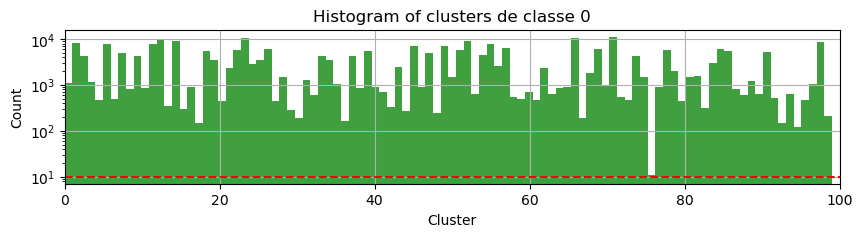

Traitement de la classe 1
Dimension du dataset de la classe de départ : (24823, 764)
réduction de dimention avant clustering (24823, 463)
ACP 99 - done in 4s
Répartition du dataset dans 100 clusters
kmeans - done in 2s


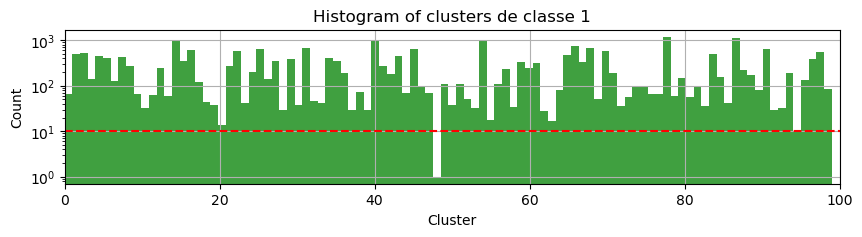

Dimension du dataset (123078, 766)


In [386]:
df_sub_40 = reduce_samples(df, ratio=0.4)

## LightGBM OptimFtwo 4

shape of the X data (123078, 761)
pipe est :u0_5sm
training dataset format for CV : 20943
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 86154     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__sampling_strategy=0.5;, score=0.445 total time=   8.9s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__sampling_strategy=0.5;, score=0.448 total time=   8.1s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, u__sampling_strategy=0.5;, score=0.439 total time=   6.7s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=300, m__n_estimators=400, 

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.05,5,400,500,0.5,0.443197,0.442881


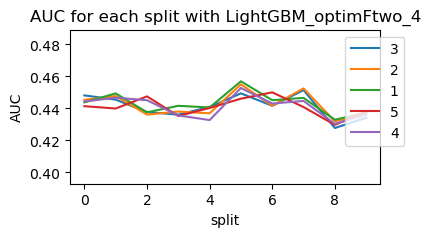

In [727]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5, 6], "m__learning_rate": [0.05], "m__min_child_samples":[300, 400],
           "m__n_estimators":[400, 500], "m__class_weight":["balanced"], #"sm__sampling_strategy" : [0.25, 0.35],
           "u__sampling_strategy":[0.5, 0.6]} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub_40, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_4_list = ["LightGBM_optimFtwo_4", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_4_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_4")
best_result_df

In [732]:
make_synthesis_df(synthesis_type="df", select_in_model="LightGBM_optimFtwo_4")

Read file


,u0_5sm
model_name,LightGBM_optimFtwo_4
best_parameters,"{m__max_depth : 5, m__min_child_samples : 400, m__n_estimators : 500, u__sampling_strategy : 0.5}"
best_result,0.443 +/- -0.0
m__max_depth,"[5, 6]"
m__learning_rate,[0.05]
m__min_child_samples,"[300, 400]"
m__n_estimators,"[400, 500]"
m__class_weight,[balanced]
u__sampling_strategy,"[0.5, 0.6]"


Read file


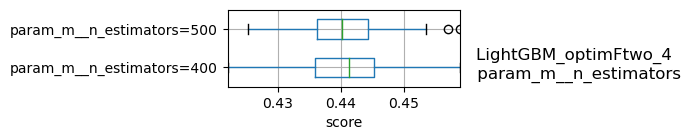

In [728]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo_4", param_name="param_m__n_estimators")

Read file


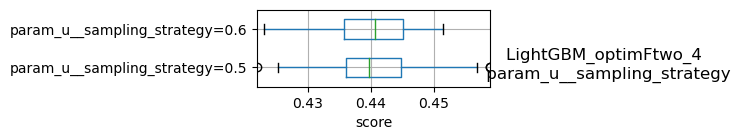

In [729]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo_4", param_name="param_u__sampling_strategy")

Read file


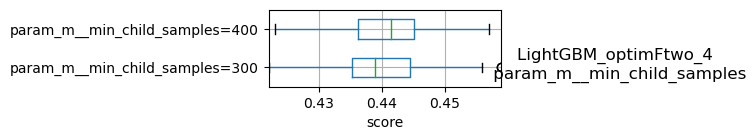

In [730]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo_4", param_name="param_m__min_child_samples")

Read file


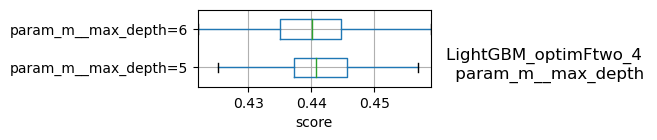

In [733]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo_4", param_name="param_m__max_depth")

## LightGBM OptimFtwo 5

shape of the X data (123078, 761)
pipe est :u0_25sm_smote0_5
the pipeline is : ['undersample_0.25', 'scaler_transform', 'smote0_5', 'model']
Nombre d'échantillon pour le training : 86154     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500, sm__sampling_strategy=0.55, u__sampling_strategy=0.5;, score=0.444 total time=   9.5s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500, sm__sampling_strategy=0.55, u__sampling_strategy=0.5;, score=0.450 total time=  10.4s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.05, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500, sm__sampling_strategy=0.55, u__sampling_strategy=0.5;, score=0.444 total time=  11.9s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.0

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,sm__sampling_strategy,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.03,5,400,500,0.55,0.5,0.442379,0.442673


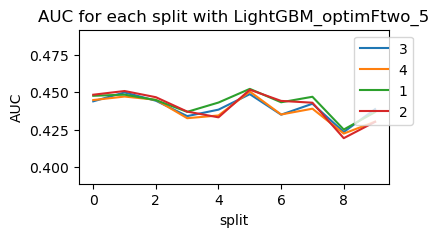

In [748]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5], "m__learning_rate": [0.05, 0.03], "m__min_child_samples":[400],
           "m__n_estimators":[500], "m__class_weight":["balanced"], "sm__sampling_strategy" : [0.55, 0.6],
           "u__sampling_strategy":[0.5]} 
pipe = "u0_25sm_smote0_5"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_sub_40, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_5_list = ["LightGBM_optimFtwo_5", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_5_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_5")
best_result_df

## Synthesis

Read file


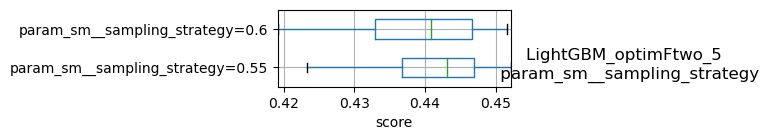

In [751]:
make_synthesis_df(synthesis_type="graph", select_in_model="LightGBM_optimFtwo_5", param_name="param_sm__sampling_strategy")

Read file


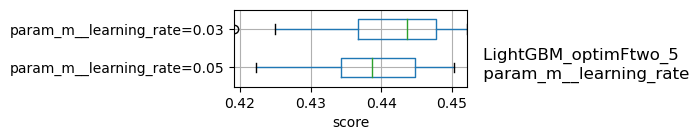

In [414]:
make_synthesis_df(synthesis_type="graph", select_in_model=["LightGBM_optimFtwo_5"], 
                  param_name="param_m__learning_rate")

In [777]:
best_result_df

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,sm__sampling_strategy,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.03,5,400,500,0.55,0.5,0.442379,0.442673


## Récupération du pipeline optimisé et d'un dataset réduit pour API

In [941]:
model = LGBMClassifier(objective="binary", max_depth=5, learning_rate=0.03, min_child_samples=400,
                       n_estimators=500, class_weight="balanced")
params =  {}

pipe = "u0_5sm"
scoring_param='ftwo_score'
model, df0, pipeline, X_control, y_control = evaluation(df_sub_40, model, params, scoring_param=scoring_param, 
                                                        pipe=pipe, grid_search=False, make_joblib_for_pythonanywhere=True)

y_pred = pipeline.predict_proba(X_control)
auc = roc_auc_score(y_control, y_pred[:,1])
print(auc)

import joblib
joblib.dump(pipeline, 'pipeline_40.joblib')
loaded_pipeline = joblib.load('pipeline_40.joblib')

Make joblib for pythonanywhere.com
shape of the X data (123078, 764)
pipe est :u0_5sm
training dataset format for CV : 20943
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 86154     Dimension des échantillons : 764
score sur dataset vu au training, auc : 0.8649166447468142
score sur dataset de controle, auc : 0.7789363427231941
0.7789363427231941


In [942]:
y_pred = loaded_pipeline.predict_proba(X_control)
auc = roc_auc_score(y_control, y_pred[:,1])
auc

0.7789363427231941

In [10]:
df.shape

(48744, 2)

Traitement de la classe 0
Dimension du dataset de la classe de départ : (282665, 764)
réduction de dimention avant clustering (282665, 488)
ACP 99 - done in 56s
Répartition du dataset dans 100 clusters
kmeans - done in 3s


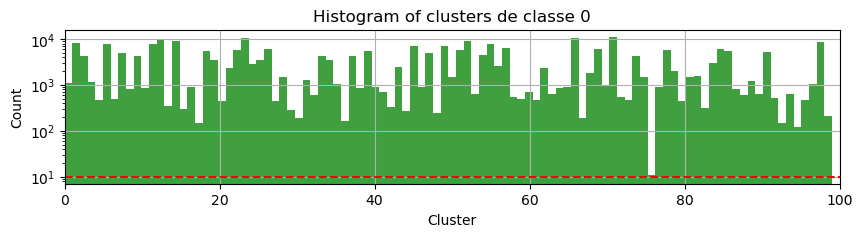

Traitement de la classe 1
Dimension du dataset de la classe de départ : (24823, 764)
réduction de dimention avant clustering (24823, 463)
ACP 99 - done in 4s
Répartition du dataset dans 100 clusters
kmeans - done in 3s


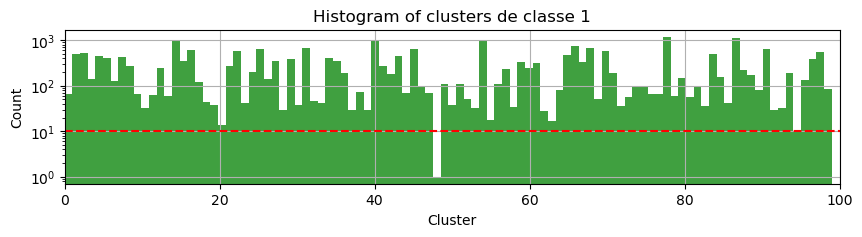

Dimension du dataset (440, 766)


In [884]:
# generate a small dataset for API
df_sub_01 = reduce_samples(df, ratio=0.001)
feats = [f for f in df_sub_01.columns if f not in ['TARGET','SK_ID_CURR']]
df_sub_01[feats].to_csv('df_sub_01.csv', index=False)

# Optimisation LightGBM avec score Ftwo_score full dataset

## LightGBM OptimFtwo 6

shape of the X data (307488, 764)
pipe est :u0_5sm
training dataset format for CV : 52128
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 215241     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.02, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500, u__sampling_strategy=0.5;, score=0.442 total time=  23.1s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.02, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500, u__sampling_strategy=0.5;, score=0.440 total time=  21.0s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.02, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500, u__sampling_strategy=0.5;, score=0.445 total time=  21.2s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.02, m__max_depth=5, m__min_child_samples=400, m__n_estimators=500,

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.03,6,400,600,0.5,0.447021,0.449371


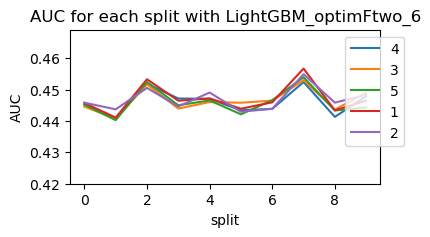

In [44]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [5, 6], "m__learning_rate": [0.02, 0.03], "m__min_child_samples":[400, 500],
           "m__n_estimators":[500, 600], "m__class_weight":["balanced"], #"sm__sampling_strategy" : [0.25, 0.35],
           "u__sampling_strategy":[0.5]} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_full, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_6_list = ["LightGBM_optimFtwo_6", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_6_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_6")
best_result_df

In [412]:
make_synthesis_df(synthesis_type="df", select_in_model="LightGBM_optimFtwo_6")

Read file


,u0_5sm
model_name,LightGBM_optimFtwo_6
best_parameters,"{m__learning_rate : 0.03, m__max_depth : 6, m__min_child_samples : 400, m__n_estimators : 600}"
best_result,0.449 +/- 0.002
m__max_depth,"[5, 6]"
m__learning_rate,"[0.02, 0.03]"
m__min_child_samples,"[400, 500]"
m__n_estimators,"[500, 600]"
m__class_weight,[balanced]
u__sampling_strategy,[0.5]


Read file


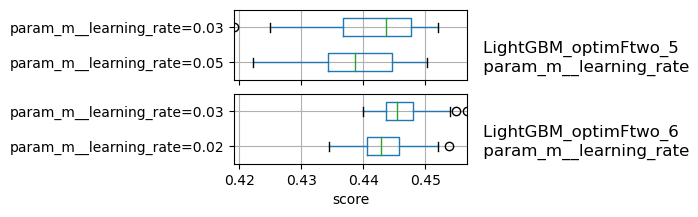

In [415]:
make_synthesis_df(synthesis_type="graph", select_in_model=["LightGBM_optimFtwo_5", "LightGBM_optimFtwo_6"], 
                  param_name="param_m__learning_rate")

Read file


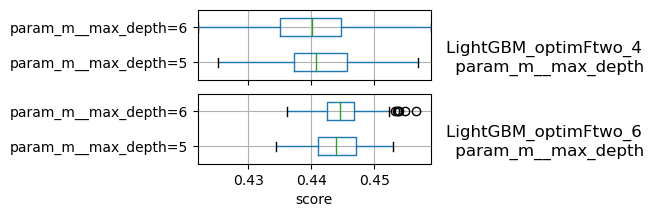

In [417]:
make_synthesis_df(synthesis_type="graph", select_in_model=["LightGBM_optimFtwo_4", "LightGBM_optimFtwo_6"], 
                  param_name="param_m__max_depth")

Read file


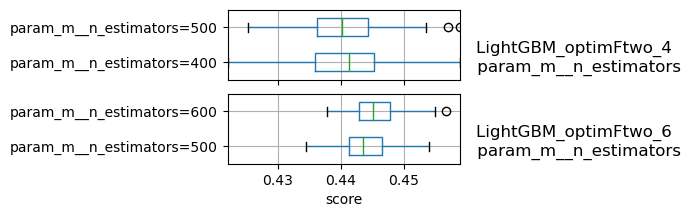

In [418]:
make_synthesis_df(synthesis_type="graph", select_in_model=["LightGBM_optimFtwo_4", "LightGBM_optimFtwo_6"], 
                  param_name="param_m__n_estimators")

Read file


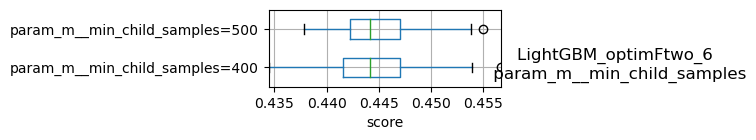

In [419]:
make_synthesis_df(synthesis_type="graph", select_in_model=["LightGBM_optimFtwo_6"], 
                  param_name="param_m__min_child_samples")

## LightGBM OptimFtwo 7

shape of the X data (307488, 764)
pipe est :u0_5sm
training dataset format for CV : 52128
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 215241     Dimension des échantillons : 764
start GridSearchCV
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END m__class_weight=balanced, m__learning_rate=0.03, m__max_depth=6, m__min_child_samples=400, m__n_estimators=600, u__sampling_strategy=0.25;, score=0.449 total time=  37.5s
[CV 2/10] END m__class_weight=balanced, m__learning_rate=0.03, m__max_depth=6, m__min_child_samples=400, m__n_estimators=600, u__sampling_strategy=0.25;, score=0.444 total time=  34.0s
[CV 3/10] END m__class_weight=balanced, m__learning_rate=0.03, m__max_depth=6, m__min_child_samples=400, m__n_estimators=600, u__sampling_strategy=0.25;, score=0.452 total time=  36.8s
[CV 4/10] END m__class_weight=balanced, m__learning_rate=0.03, m__max_depth=6, m__min_child_samples=400, m__n_estimators=600

,m__class_weight,m__learning_rate,m__max_depth,m__min_child_samples,m__n_estimators,u__sampling_strategy,best mean score,Control Set score
best result,balanced,0.03,6,500,600,0.25,0.448591,0.453325


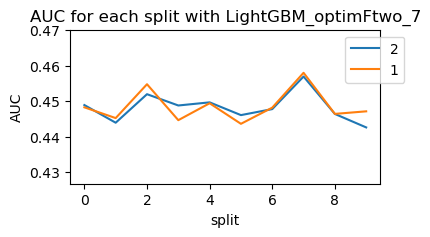

In [421]:
model = LGBMClassifier(objective="binary")

params =  {'m__max_depth': [6], "m__learning_rate": [0.03], "m__min_child_samples":[400, 500],
           "m__n_estimators":[600], "m__class_weight":["balanced"], #"sm__sampling_strategy" : [0.25, 0.35],
           "u__sampling_strategy":[0.25]} 
pipe = "u0_5sm"
scoring_param='ftwo_score'
best_result_df, split_results_df, results_df = evaluation(df_full, model, params, scoring_param=scoring_param, pipe=pipe) 

LightGBM_optimFtwo_7_list = ["LightGBM_optimFtwo_7", best_result_df, split_results_df, results_df, params, pipe]
savedata(LightGBM_optimFtwo_7_list)
AUC_split_graph(split_results_df, results_df, titre="LightGBM_optimFtwo_7")
best_result_df

## Création d'un pipeline avec le modèle optimisé 100% des données

In [445]:
model = LGBMClassifier(objective="binary", max_depth=6, learning_rate=0.03, min_child_samples=400,
                       n_estimators=600, class_weight="balanced")
params =  {}

pipe = "u0_5sm"
scoring_param='ftwo_score'
model, df0, pipeline, X_control, y_control = evaluation(df_full, model, params, scoring_param=scoring_param, 
                                                        pipe=pipe, grid_search=False) #, make_joblib_for_pythonanywhere=True)

y_pred = pipeline.predict_proba(X_control)
auc = roc_auc_score(y_control, y_pred[:,1])
print(auc)

import joblib
joblib.dump(pipeline, 'pipeline_100.joblib')
loaded_pipeline = joblib.load('pipeline_100.joblib')

y_pred = loaded_pipeline.predict_proba(X_control)
auc = roc_auc_score(y_control, y_pred[:,1])
print(auc)

shape of the X data (307488, 764)
pipe est :u0_5sm
training dataset format for CV : 52128
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 215241     Dimension des échantillons : 764
(52128, 2)
(52128,)
score sur dataset vu au training, auc : 0.8547852764783838
score sur dataset vu au training, f_2 : 0.7448185817890567
score sur dataset vu au training, f_10 : 0.7794716920213797
score sur dataset de controle, auc : 0.7851994724987396
score sur dataset vu au training, f_2 : 0.4493714482521095
score sur dataset vu au training, f_10 : 0.6819292040435612
0.7851994724987396


In [447]:
model = LGBMClassifier(objective="binary", max_depth=8, learning_rate=0.02, min_child_samples=600,
                       n_estimators=700, class_weight="balanced")
params =  {}

pipe = "u0_5sm"
scoring_param='ftwo_score'
model, df0, pipeline, X_control, y_control = evaluation(df_full, model, params, scoring_param=scoring_param, 
                                                        pipe=pipe, grid_search=False)

shape of the X data (307488, 764)
pipe est :u0_5sm
training dataset format for CV : 52128
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 215241     Dimension des échantillons : 764
(52128, 2)
(52128,)
score sur dataset vu au training, auc : 0.8517133087879305
score sur dataset vu au training, f_2 : 0.7416501331813349
score sur dataset vu au training, f_10 : 0.7768502124394299
score sur dataset de controle, auc : 0.7858766699772733
score sur dataset vu au training, f_2 : 0.45203031292423496
score sur dataset vu au training, f_10 : 0.6873076748953892


In [ ]:
model = LGBMClassifier(objective="binary", max_depth=8, learning_rate=0.02, min_child_samples=800,
                       n_estimators=1500, class_weight="balanced")
params =  {}

pipe = "u0_5sm"
scoring_param='ftwo_score'
model, df0, pipeline, X_control, y_control = evaluation(df_full, model, params, scoring_param=scoring_param, 
                                                        pipe=pipe, grid_search=False)

shape of the X data (307488, 764)
pipe est :u0_5sm
training dataset format for CV : 52128
the pipeline is : ['undersample_0.5', 'scaler_transform', 'model']
Nombre d'échantillon pour le training : 215241     Dimension des échantillons : 764
(52128, 2)
(52128,)
score sur dataset vu au training, auc : 0.8856470530651919
score sur dataset vu au training, f_2 : 0.777906399867703
score sur dataset vu au training, f_10 : 0.8103884407616325
score sur dataset de controle, auc : 0.7867510961106282
score sur dataset vu au training, f_2 : 0.4509467341612513
score sur dataset vu au training, f_10 : 0.6736359832798577


# Test

In [ ]:
clf = LGBMClassifier(
    n_jobs=4,
    # nthread=4,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    
    learning_rate=0.02,
    max_depth=8,
    n_estimators=10000,

In [ ]:
# ================ Exemples de Traitement des données déséquilibrées =============================
# cost-sensitive learning

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# load dataset
data = pd.read_csv('abc.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
# define model
model = DecisionTreeClassifier(class_weight='balanced')
# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean AUROC: %.3f' % np.mean(scores))

## see https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4 for other cost sensitive learning
## for exemple for XGBOOST

# Combinaison de oversampling et undersampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier# define model
model = DecisionTreeClassifier()
# define pipeline
oversample = SMOTE(sampling_strategy=0.1)
undersample = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', oversample), ('u', undersample), ('m', model)]
pipeline = Pipeline(steps=steps)
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# exemple avec GridSearchCV
from imblearn.pipeline import Pipeline
model = Pipeline([('sampling', SMOTE()), ('classification', LogisticRegression()) ])

grid = GridSearchCV(model, params, ...)
grid.fit(X, y)



Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
Starting LightGBM. Train shape: (10000, 768), test shape: (10000, 768)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.844837	training's binary_logloss: 0.211008	valid_1's auc: 0.761639	valid_1's binary_logloss: 0.265962
[400]	training's auc: 0.88292	training's binary_logloss: 0.192999	valid_1's auc: 0.762533	valid_1's binary_logloss: 0.264988
Early stopping, best iteration is:
[346]	training's auc: 0.874052	training's binary_logloss: 0.19723	valid_1's auc: 0.765036	valid_1's binary_logloss: 0.264362
Fold  

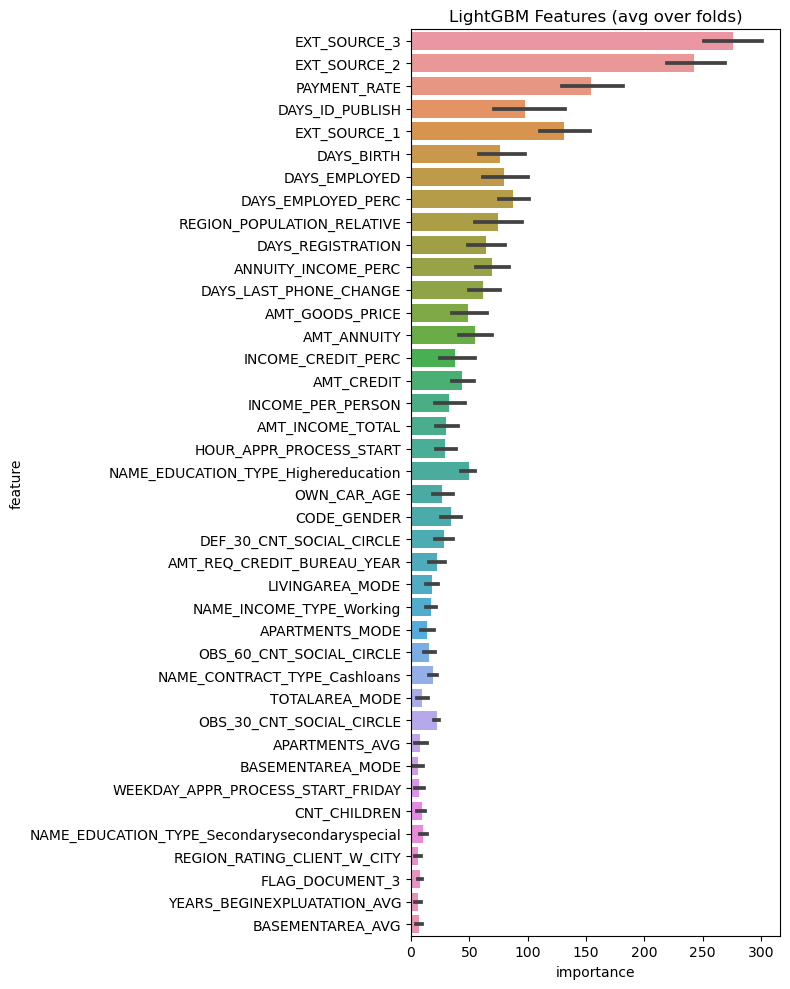

In [ ]:
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df = dataengineering(debug = True)
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= True, debug= debug)